<a id = 'top'></a>
# Исследование причин убытков в маркетинге
Компания Procrastinate Pro+. Отдел маркетинговой аналитики.

Дата: 01.11.2019.
___

<a id = 'intro'></a>
## [Введение](#plan)
Описание проблемы: несмотря на крупные инвестиции в рекламу продукта, компания несколько месяцев терпит убытки по неизвестным причинам. Бизнес-план предусматривает окупаемость пользователей не позднее чем через две недели после привлечения. Дата проведения анализа: 01.11.2019. Необходимо выявить причины и источники убыточности.

<a id = 'plan'></a>
### [План исследования](#top)

1. [Введение](#intro).
   * 1.1 [План исследования](#plan)
   * 1.2 [Исходные данные](#description)
   * 1.3 [Библиотеки и функции](#libraries)
   * 1.4 [Загрузка данных](#loading)
2. [Обзор и предобработка](#overview)
   * 2.1 [Обзор](#view)
   * 2.2 [Предобработка данных](#preprocessing)
   * 2.3 [Итоги раздела](#partition_summary_0)
3. [Исследование](#research)
   * 3.1 [Профили пользователей](#user_profiles)
   * 3.2 [Страны](#countries)
   * 3.3 [Устройства](#devices)
   * 3.4 [Рекламные каналы](#channels)
   * 3.5 [Дополнительный раздел](#extra_section)
   * 3.6 [Итоги раздела](#partition_summary_1)
4. [Маркетинг и расходы](#payment)
5. [Оценка окупаемости](#overpayment)
   * 5.1 [Общая оценка окупаемости](#score_overview)
   * 5.2 [Конверсия](#conversion)
   * 5.3 [Удержание](#retention)
   * 5.4 [Метрики по устройствам](#device_metrics)
   * 5.5 [Метрики по странам](#country_metrics)
   * 5.6 [Метрики по рекламным каналам](#channel_metrics)
   * 5.7 [Вывод по разделу](#partition_summary_2)
6. [Итоги исследования](#final_results)

<a id = 'description'></a>
### [Исходные данные](#plan)

Данные предаставленны за временной промежуток: 01.05.2019 - 27.10.2019 (~полгода).\
Бизнес-план предусматривает окупаемость пользователей за 2 недели. Горизонт анализа = 14 дней.

Предаставленные данные о пользователях: <p>
- visits_info_short.csv - лог сервера с данными об их посещениях :
    - `User Id` — уникальный идентификатор пользователя,
    - `Region` — страна пользователя,
    - `Device` — тип устройства пользователя,
    - `Channel` — идентификатор источника перехода,
    - `Session Start` — дата и время начала сессии,
    - `Session End` — дата и время окончания сессии. 
    </p><p>
- orders_info_short.csv - выгрузка их покупок за этот период:
    - `User Id` — уникальный идентификатор пользователя,
    - `Event Dt` — дата и время покупки,
    - `Revenue` — сумма заказа.
    </p><p>
- costs_info_short.csv - рекламные расходы:
    - `dt` — дата проведения рекламной кампании,
    - `Channel` — идентификатор рекламного источника,
    - `costs` — расходы на эту кампанию.
    </p>

Дополнительно:
- Названия столбцов не стандартизированны.
- Потенциальные точки соединения датасетов: идентификаторы пользователей (user_id), дата и/или время, каналы (channels).

<a id = 'libraries'></a>
### [Библиотеки и функции](#plan)
В проекте используються перечисленные далее библиотеки и функции.

**Библиотеки**

In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import os

**Функции**

- `about_data` - общее поверхностное описание данных,
- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [2]:
def about_data(data, df_columns_list = [], limits = 'yes', limit_rows = 100000, limit_columns = 50, extension = False): 
    """
    V 1.1
    """
#-------------------------------------------------------------------------------------------------Коррекция входных параметров
    ##------------------------------------------------------------------------------------------------Проверка типа передачи колонок
    if type(df_columns_list) != list:
        df_columns_list = [df_columns_list]
        print('⚠️ Warning. The type of inputs at the field "df_columns_list" should be "list".✅ Input value is converted to list now.')
    ##------------------------------------------------------------------------------------------------Проверка корректности ввода limits
    limits = limits.lower()
    if limits == 'y':
        limits = 'yes'
    elif limits == 'n':
        limits = 'no'
    elif limits == 'r':
        limits = 'rows'
    elif limits == 'c':
        limits = 'columns'
    elif limits == 'rows' or limits == 'columns' or limits == 'yes' or limits == 'no':
        pass
    else:
        limits = 'yes'
        print('❌ Error. Incorrect input in the field "limits".✅ Setting set to default.')
    ##------------------------------------------------------------------------------------------------Проверка типа и размеров ограничителей строк/столбцов 
    try:
        limit_rows = round(limit_rows)
    except:
        print('❌ Error. Incorrect input in the field "limit_rows" (must be type "integer").✅ Setting set to default.')
        limit_rows = 100000 
    try:
        limit_columns = round(limit_columns)
    except: 
        print('❌ Error. Incorrect input in the field "limit_columns" (must be type "integer").✅ Setting set to default.')
        limit_columns = 50
    ###-----------------------------------------------------------------------------------------------Проверка корректности установки limits в зависимости от размеров ограничителей
    if limit_rows == 0 and limit_columns != 0:
        limits = 'columns'
    elif limit_rows != 0 and limit_columns == 0:
        limits = 'rows'
    elif limit_rows == 0 and limit_columns == 0:
        limits = 'no'
        print('⚠️ Warning. Column and row limits are set: "0". ✅ The limits setting set to "No".')
#-------------------------------------------------------------------------------------------------Оценка переданных данных
    ##---------------Результаты обобщения
    name_columns = []
    nan_info = []
    dupls = []
    nuniq = []
    total_row = True
##---------------------------------------------------------------------------------------------Обработка и оценка в соотвествии с типом
    if str(type(data)) == "<class 'pandas.core.frame.DataFrame'>":
        print('➡️ Entered data type: DataFrame')
        
        if len(df_columns_list) > 0:
            checked_columns_list = []
            for i, name in enumerate(df_columns_list):
                if name in data.columns:
                    checked_columns_list.append(name)
                else:
                    print(f"❌ Error. The column '{name}' at position {i+1} is not part of entered DataFrame. ✅ Column was ignored.")
            if len(checked_columns_list) == 0:
                checked_columns_list = data.columns
                print("⚠️ Warning. All entered columns was ignored. ✅ All available columns will be used.")
            data = data[checked_columns_list]
            if len(df_columns_list) == 1:
                total_row = False
            else:
                total_row = True   
                
        rows_size, columns_size = data.shape 

        if (limits == 'yes' or limits == 'rows') and rows_size > limit_rows:

            data = data.loc[data.index[:limit_rows]]
            print(f'✅ Row limit set: {limit_rows}')
            
        if (limits == 'yes' or limits == 'columns') and columns_size > limit_columns:
            data = data[data.columns[:limit_columns]]
            print(f'✅ Сolumn limit set: {limit_columns}')

        for column_name in data.columns:
            name_columns.append(column_name)
            nan_info.append(data[column_name].isna().sum())
            dupls.append(data[data[column_name].isna() == False][column_name].duplicated().sum())
            nuniq.append(data[column_name].nunique())
            
        cells = (data.shape[0]*data.shape[1])
        
        if extension:
            try:
                about_data_visual_extention(data, df_columns_list = [], limits = limits, limit_rows = limit_rows, limit_columns = limit_columns)
            except:
                print("❌ Error. Visual extention is not available")
                
    elif str(type(data)) == "<class 'pandas.core.series.Series'>":

        print('➡️ Entered data type: Series')
        if len(df_columns_list) > 0: 
            print("❌ Error. Series don't have columns. ✅ Field 'df_columns_list' was passed.")
            
        if (limits == 'yes' or limits == 'rows') and len(data) > limit_rows:
            data = data.loc[data.index[:limit_rows]]  
            print(f'✅ Row limit set: {limit_rows}')
          
        nan_info = data.isna().sum()
        name_columns.append('Series')
        dupls.append(data[data.isna() == False].duplicated().sum())
        nuniq.append(data.nunique())
        cells = data.shape[0]
        total_row = False
        
        if extension:
            try:
                about_data_visual_extention(data, df_columns_list = [], limits = limits, limit_rows = limit_rows, limit_columns = limit_columns)
            except:
                print("❌ Error. Visual extention is not available")
                
    elif data == "author":
        return print('➡️ Hi there! I wrote this code to help people do data analysis. Together we can achieve more!\n✅ Want to help or discuss? My github:','https://github.com/Linecore')
    
    else: #For Other Types of Data Storage
        return print('❌ Error. Incorrect type of data entered. Pandas Dataframe or Series only for now')
#----------------------------------------------------------------------------------------------------------Сбор обобщённой информации в фрейм для вывода      
    info_df = pd.DataFrame(data = nan_info, index = name_columns, columns = ['total_nan'])
    info_df['%_nan'] = round((info_df['total_nan'] / data.shape[0])*100,2)
    info_df['duplicated'] = dupls
    info_df['nunique'] = nuniq
    info_df['non_null'] = data.shape[0] - info_df['total_nan']
    info_df = info_df.sort_values(by='total_nan')
    info_df['type'] = data.dtypes
    if total_row:
        info_df.loc[f'TOTAL: {len(info_df)}'] = [info_df[info_df['total_nan'] != 0]['total_nan'].count(),  
                                                 round((info_df['total_nan'].sum()/cells)*100,2),
                                                 data.duplicated().sum(),
                                                 data.shape[0] - data.duplicated().sum(),
                                                 data.dropna().shape[0],
                                                 info_df['type'].nunique()]
    return info_df

In [3]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                        .groupby('user_id')
                        .agg({'session_start': 'first',
                              'channel': 'first',
                              'device': 'first',
                              'region': 'first'})
                        .rename(columns={'session_start': 'first_ts'})
                        .reset_index())
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (profiles.groupby(['dt', 'channel'])
                         .agg({'user_id': 'nunique'})
                         .rename(columns={'user_id': 'unique_users'})
                         .reset_index())
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],
                                    on=['dt', 'channel'],
                                    how='left')
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

In [4]:
# функция для расчёта удержания
def get_retention(profiles,
                  sessions,
                  observation_date,
                  horizon_days,
                  dimensions=[],
                  ignore_horizon=False):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], 
                                          on='user_id', 
                                          how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, 
                                columns='lifetime',
                                values='user_id',
                                aggfunc='nunique')
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [5]:
# функция для расчёта конверсии
def get_conversion (profiles,
                    purchases,
                    observation_date,
                    horizon_days,
                    dimensions=[],
                    ignore_horizon=False):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
                                .groupby('user_id')
                                .agg({'event_dt': 'first'})
                                .reset_index())
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []
    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [6]:
# функция для расчёта LTV и ROI
def get_ltv(profiles,
            purchases,
            observation_date,
            horizon_days,
            dimensions=[],
            ignore_horizon=False):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        # считаем средний CAC по параметрам из dimensions
        cac = (cac.groupby(dims)
                  .agg({'acquisition_cost': 'mean'})
                  .rename(columns={'acquisition_cost': 'cac'}))
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']
        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        # возвращаем таблицы LTV и ROI
        return result, roi
    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return (result_raw,  # сырые данные
            result_grouped,  # таблица LTV
            result_in_time,  # таблица динамики LTV
            roi_grouped,  # таблица ROI
            roi_in_time)  # таблица динамики ROI

**Функции визуализации**

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [7]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [8]:
# функция для визуализации удержания
def plot_retention(retention, 
                   retention_history, 
                   horizon, 
                   window=7):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))
    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(index='dt', 
                                                                         columns=columns, 
                                                                         values=horizon - 1, 
                                                                         aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))
    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(index='dt', 
                                                                          columns=columns, 
                                                                          values=horizon - 1, 
                                                                          aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

In [9]:
# функция для визуализации конверсии
def plot_conversion(conversion, 
                    conversion_history, 
                    horizon, 
                    window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))
    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in conversion_history.index.names if name not in ['dt']] 
    filtered_data = conversion_history.pivot_table(index='dt', 
                                                   columns=columns, 
                                                   values=horizon - 1, 
                                                   aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

In [10]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, 
                 ltv_history, 
                 roi, 
                 roi_history, 
                 horizon, 
                 window=7):
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(14, 13))
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]
    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]
    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', 
                                            columns=columns, 
                                            values=horizon - 1, 
                                            aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 5, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 3)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 4, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', 
                                            columns=columns, 
                                            values=horizon - 1, 
                                            aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

<a id = 'loading'></a>
### [Загрузка данных](#plan)

In [11]:
#---------------------------------------------------------------------------------Local Paths
path_A1 = 'C:\\'
path_A2 = 'C:\\'
path_A3 = 'C:\\'
#---------------------------------------------------------------------------------Online Paths
path_B1 = 'https://'
path_B2 = 'https://'
path_B3 = 'https://'
#---------------------------------------------------------------------------------Loading...
if os.path.exists(path_A1) and os.path.exists(path_A2) and os.path.exists(path_A3):
    visits = pd.read_csv(path_A1)
    orders = pd.read_csv(path_A2)
    costs = pd.read_csv(path_A3)
    print('🖥️ \033[1m\033[92m\033[4mLoad from localhost.\033[0m')
else:
    try:
        visits = pd.read_csv(path_B1)
        orders = pd.read_csv(path_B2)
        costs = pd.read_csv(path_B3)
        print('🌐 \033[1m\033[94m\033[4mLoad from online.\033[0m')
    except:
        print('🔌\033[1m\033[91m\033[4mLocal file is missing. Load from online is not available. Check paths, access or ping servers.\033[0m')

🖥️ Load from localhost.


<a id = 'overview'></a>
## [Обзор и предобработка](#plan)

<a id = 'view'></a>
### [Обзор](#plan)
**A) visits**

Посмотрим содержание датафрейма visits.

In [12]:
display(visits.info(), 
        about_data(visits, limits="no"), 
        f'Дубликатов строк: {visits.duplicated().sum()}', 
        visits.head(), 
        f"Начальная дата {visits['Session Start'].min()}", 
        f"Конечная дата {visits['Session Start'].max()}")
for i in visits.columns[1:4]:
    print(f"Уникальные значения колонки {i}: {visits[i].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
➡️ Entered data type: DataFrame


None

total_nan  %_nan  duplicated   nunique  non_null    type
User Id              0.0    0.0    159893.0  150008.0  309901.0   int64
Region               0.0    0.0    309897.0       4.0  309901.0  object
Device               0.0    0.0    309897.0       4.0  309901.0  object
Channel              0.0    0.0    309890.0      11.0  309901.0  object
Session Start        0.0    0.0      3088.0  306813.0  309901.0  object
Session End          0.0    0.0      3108.0  306793.0  309901.0  object
TOTAL: 6             0.0    0.0         0.0  309901.0  309901.0     2.0

'Дубликатов строк: 0'

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

'Начальная дата 2019-05-01 00:00:41'

'Конечная дата 2019-10-31 23:59:23'

Уникальные значения колонки Region: ['United States' 'UK' 'France' 'Germany']
Уникальные значения колонки Device: ['iPhone' 'Mac' 'Android' 'PC']
Уникальные значения колонки Channel: ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


* Регионы пользователей - Америка и Европа. Страны: 'United States', 'UK', 'France', 'Germany'
* 10 платных каналов и канал organic ("бесплатны" - пришедшие сами).
* Пользователи пользуются четыремя платформами: 'iPhone', 'Mac', 'Android', 'PC'.

- В датафрейме отсуствуют пропуски и дубликаты строк.
- Уникальных пользователей (User Id) 150008, что составляет примерно половину посещений за выбранный промежуток времени. То есть значительное число пользователей возвращалось повторно.
-  Временной интервал соответсвует заявленному: 2019-05-01 00:00:41 - 2019-10-31 23:59:23.
-  Колонки Session Start и Session End приведём к формату datetime64.
-  Названия колонок приведём в нижний регистр.
-  Есть дубликаты в Session Start - это вполне допустимо, но стоит проверить на отсутствие технических ошибок. Дубликаты в остальных колонках - допустимы, так как пользователи могут перемещаться по миру и осуществлять переходы с разных интернет-ресурсов с различными размещёнными на них каналами привлечения.

Сделаем срез по дубликатам Session Start и проверим уникальность комбинаций User Id и Session Start.

In [13]:
print('Неявных дубликотов:', 
      visits.loc[visits.duplicated(subset = 'Session Start', keep = False),
                ['User Id','Session Start']].duplicated().sum())

Неявных дубликотов: 0


Неявные дубликаты строк отсуствуют. 

**B) orders**

Посмотрим содержание датафрейма orders.

In [14]:
display(orders.info(), 
        about_data(orders), 
        f'Дубликатов строк: {orders.duplicated().sum()}', 
        orders.head(), 
        f"Начальная дата {orders['Event Dt'].min()}", 
        f"Конечная дата {orders['Event Dt'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
➡️ Entered data type: DataFrame


None

total_nan  %_nan  duplicated  nunique  non_null     type
User Id         0.0    0.0     31331.0   8881.0   40212.0    int64
Event Dt        0.0    0.0        49.0  40163.0   40212.0   object
Revenue         0.0    0.0     40207.0      5.0   40212.0  float64
TOTAL: 3        0.0    0.0         0.0  40212.0   40212.0      3.0

'Дубликатов строк: 0'

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

'Начальная дата 2019-05-01 00:28:11'

'Конечная дата 2019-10-31 23:56:56'

- В датафрейме отсуствуют пропуски и дубликаты строк.
- Временной промежуток соотвествует заявленному: 2019-05-01 00:28:11 - 2019-10-31 23:56:56.
- Уникальных пользователей 8881, при том, что заказов сделано 40212.
-  Столбец Event Dt приведём к формату date. Так же все названия колонок стандартизировать. Проверим Event Dt на наличие неявных дубликатов тем же методом, что и раньше.

In [15]:
print('Неявных дубликотов:', 
      orders.loc[orders.duplicated(subset = 'Event Dt', keep = False),
                ['User Id','Event Dt']].duplicated().sum())

Неявных дубликотов: 0


Неявных дубликатов - не оказалось.

**C) costs**

Посмотрим содержание датафрейма costs.

In [16]:
costs[costs.columns[1]].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [17]:
display(costs.info(), 
        about_data(costs), 
        f'Дубликатов строк: {costs.duplicated().sum()}', 
        costs.head(), 
        f"Начальная дата {costs['dt'].min()}", 
        f"Конечная дата {costs['dt'].max()}",
        f"Каналы: {costs[costs.columns[1]].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
➡️ Entered data type: DataFrame


None

total_nan  %_nan  duplicated  nunique  non_null     type
dt              0.0    0.0      1620.0    180.0    1800.0   object
Channel         0.0    0.0      1790.0     10.0    1800.0   object
costs           0.0    0.0      1192.0    608.0    1800.0  float64
TOTAL: 3        0.0    0.0         0.0   1800.0    1800.0      2.0

'Дубликатов строк: 0'

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

'Начальная дата 2019-05-01'

'Конечная дата 2019-10-27'

"Каналы: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'\n 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'\n 'lambdaMediaAds']"

In [18]:
print('Неявных дубликотов:', 
      costs.loc[costs.duplicated(subset = 'dt', keep = False),
                ['Channel','dt']].duplicated().sum())

Неявных дубликотов: 0


- Пропуски, дубликаты строк и неявные дубликаты - отсутствуют в датасете.
- Временной промежуток соотвествует заявленному.
- Столбец dt преведём к date-формату.
- Названия колонок приведём к нижнему регистру.
- Все платные каналы на месте.

**Итоги**

- Пропуски, неявные и полные дубликаты строк во всех трёх датасетах отсутствуют.
- Промежуток времени данных соотвествует заявленному и составляет 179 дней. Для visits немного больше - 183 дня.
- Во всех датафреймах приведём названия колонок к нижнему регистру.
- Колонки с временем и датай приведём к типу datetime64.

<a id = 'preprocessing'></a>
### [Предобработка данных](#plan)
Добавим колонки с месяцем во все датафреймы.

In [19]:
visits['month'] = pd.to_datetime(visits['Session Start']).dt.month
orders['month'] = pd.to_datetime(orders['Event Dt']).dt.month
costs['month'] = pd.to_datetime(costs['dt']).dt.month

Во всех датафреймах приведём названия колонок к нижнему регистру. Колонки с датой приведём к формату datatime.

**Датафрейм visits**

In [20]:
visits = visits.rename(columns = {'User Id':'user_id', 
                                   'Region':'region', 
                                   'Device':'device', 
                                   'Channel':'channel', 
                                   'Session Start':'session_start',
                                   'Session End':'session_end', 
                                   'month':'month'})
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits['month'] = visits['month'].astype('int8')
display (visits.info(), visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   month          309901 non-null  int8          
dtypes: datetime64[ns](2), int64(1), int8(1), object(3)
memory usage: 14.5+ MB


None

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  month  
0 2019-05-01 02:45:01      5  
1 2019-05-01 04:47:35      5  
2 2019-05-01 15:32:08      5  
3 2019-05-01 00:54:25      5  
4 2019-05-01 03:57:40      5

**Датафрейм orders**

In [21]:
orders = orders.rename(columns = {'User Id':'user_id', 
                                   'Event Dt':'event_dt', 
                                   'Revenue':'revenue',  
                                   'month':'month'})
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders['month'] = orders['month'].astype('int8')
display (orders.info(), orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
 3   month     40212 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1)
memory usage: 981.9 KB


None

user_id            event_dt  revenue  month
0  188246423999 2019-05-01 23:09:52     4.99      5
1  174361394180 2019-05-01 12:24:04     4.99      5
2  529610067795 2019-05-01 11:34:04     4.99      5
3  319939546352 2019-05-01 15:34:40     4.99      5
4  366000285810 2019-05-01 13:59:51     4.99      5

**Датафрейм costs**

In [22]:
costs = costs.rename(columns = {'dt':'dt', 
                                   'Channel':'channel', 
                                   'costs':'costs',  
                                   'month':'month'})
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs['month'] = costs['month'].astype('int8')
display(costs.info(), costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
 3   month    1800 non-null   int8   
dtypes: float64(1), int8(1), object(2)
memory usage: 44.1+ KB


None

dt   channel  costs  month
0  2019-05-01  FaceBoom  113.3      5
1  2019-05-02  FaceBoom   78.1      5
2  2019-05-03  FaceBoom   85.8      5
3  2019-05-04  FaceBoom  136.4      5
4  2019-05-05  FaceBoom  122.1      5

**Итоги**
Названия колонок во всех датафреймах привели к стандартному snake_case.
Колокнки с датой и временем привели к формату datetime64. Так же во всех датафреймах появилась колонка month в формате int8.

<a id = 'partition_summary_0'></a>
### [Итоги раздела](#plan)

**A) visits**

In [23]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   month          309901 non-null  int8          
dtypes: datetime64[ns](2), int64(1), int8(1), object(3)
memory usage: 14.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
 3   

**Итого**

Названия колонок во всех датафреймам приведены к snake_case. Колонки с датой и временем приведены к типу datetime.
Данные подготовлены к исследованию.

- География пользователей представлена четыремя странами (двумя регионами): 'United States', 'UK', 'France', 'Germany'.
- Пользователи привлекались по 10 платным и 1 "бесплатному" (organic) каналам.
- Клиенты использовали 4 платформы взаимодействия с сервисом: 'iPhone', 'Mac', 'Android', 'PC'.
___

<a id = 'research'></a>
## [Исследование](#plan)

<a id = 'user_profiles'></a>
### [Профили пользователей](#plan)
Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей.

In [24]:
profiles = get_profiles(visits, orders, costs)
profiles['month'] = profiles['month'].dt.month
display(profiles.head(), f"Количество профилей: {profiles.shape[0]}",
        f'Привлечение новых пользователей c {profiles["dt"].min()} по {profiles["dt"].max()}',
        f"Количество покупателей из канала organic: {profiles.loc[profiles['channel'] == 'organic', 'payer'].sum()}")

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt  month  payer  acquisition_cost  
0  2019-05-07      5   True          1.088172  
1  2019-07-09      7  False          1.107237  
2  2019-10-01     10  False          0.000000  
3  2019-08-22      8  False          0.988235  
4  2019-10-02     10  False          0.230769

'Количество профилей: 150008'

'Привлечение новых пользователей c 2019-05-01 по 2019-10-27'

'Количество покупателей из канала organic: 1160'

Построим графики привлечения новых пользователей по месяцам, а так же соотношение посетителей к покупателям вцелом за весь период.

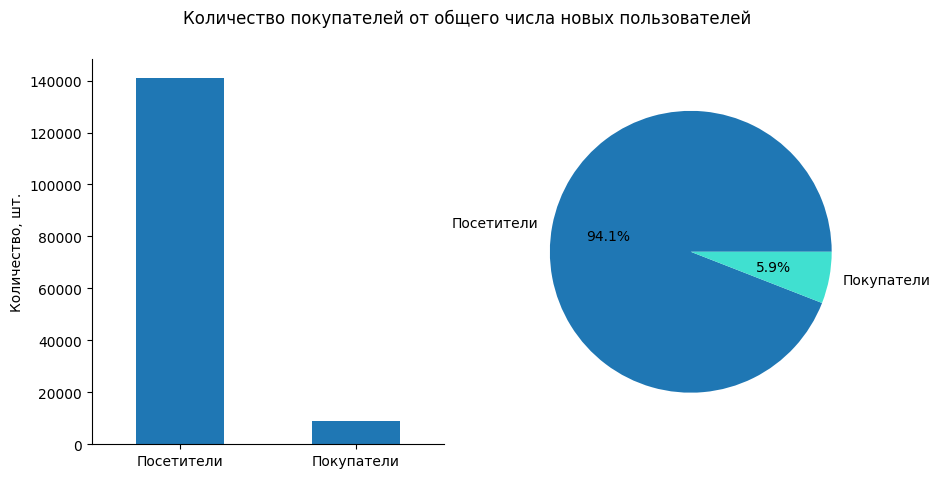

In [25]:
work_data = (profiles['payer'].value_counts()
             .rename(index = {False: 'Посетители', True:'Покупатели'}))

fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.suptitle('Количество покупателей от общего числа новых пользователей')
work_data.plot(kind = 'bar', ax = ax[0],  rot=0, ylabel = 'Количество, шт.')
ax[1].pie(work_data,
          labels=work_data.index, autopct='%1.1f%%',colors=['tab:blue','turquoise'])
sns.despine()
plt.show()

- Всего новых пользователей - 150008.
- Из них количество посетителей составляет 94.1 % (141127).
- Из них количество посетителей составляет 5.9 % (8881).
- Привлечение новых пользователей c 2019-05-01 по 2019-10-27.
- Количество покупателей из канала organic: 1160.

<a id = 'countries'></a>
### [Страны](#plan)
Исследуем из каких стран новые пользователи приходят в приложение и на какие страны приходиться больше покупающих пользователей.

In [26]:
work_data = profiles.groupby('region').agg({'user_id':'count', 'payer':'sum'})
work_data['payer_pct'] = round(work_data['payer']/work_data['user_id']*100,2)
work_data['new_users_pct'] = round(work_data['user_id']/profiles.shape[0] * 100,1)
work_data

user_id  payer  payer_pct  new_users_pct
region                                                 
France           17450    663       3.80           11.6
Germany          14981    616       4.11           10.0
UK               17575    700       3.98           11.7
United States   100002   6902       6.90           66.7

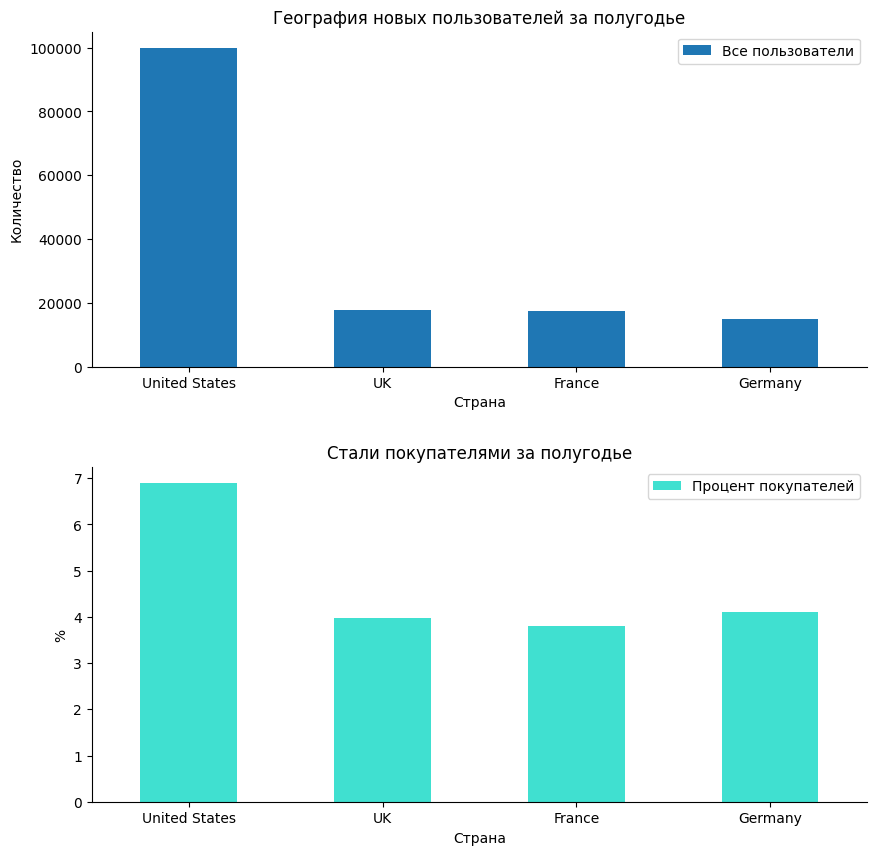

In [27]:
graph_data = (work_data.sort_values(by='user_id',ascending = False)
         .rename(columns = {'user_id':'Все пользователи', 
                            'payer':'Покупатели',
                            'payer_pct':'Процент покупателей'}))
fig, ax = plt.subplots(2,1, figsize = (10,10))
plt.subplots_adjust(hspace=0.3)
ax[0].set_title('География новых пользователей за полугодье')
(graph_data.plot(y = 'Все пользователи', kind = 'bar', rot = 0,
              xlabel = 'Страна', ylabel = 'Количество',
              ax = ax[0]))
ax[1].set_title('Стали покупателями за полугодье')
(graph_data.plot(y = 'Процент покупателей', kind = 'bar', rot = 0,
              xlabel = 'Страна', ylabel = '%',
              ax = ax[1], color = 'turquoise'))
sns.despine()
plt.show()

- Больше всего посетителей и покупателей из United States (100002 посетителя, 6.9 % покупателей).
- Из стран Europe меньше всего посетителей из Germany, но больше всего покупателей (14981 посетителей, 4.1 % покупателей).
- Посетителей из UK больше, чем из остальных стран Europe, а покупателей немного меньше, чем в Germany (17575 посетителей, 4 % покупателей).
- Посетителей из France немного меньше, чем из UK, а покупателей меньше всего, чем в остальных странах Europe (17450 посетителей, 3.8 % покупателей).

Основной приток новых посетителей и покупателей из United States. В Germany посетители чаще становяться покупателями по сравнению с остальными странами Europe. Во France больше смотрять, чем покупают. В UK посетителей больше всего из стран Europe и хороший процент покупателей.

<a id = 'devices'></a>
### [Устройства](#plan)
Исследуем какимим устройствами (платформами) пользуются новые пользователи и какими чаще пользуються пользовтели ставшие покупателями.

In [28]:
work_data = profiles.groupby('device').agg({'user_id':'count','payer':'sum'})
work_data['payer_pct'] = round(work_data['payer']/work_data['user_id']*100,2)
work_data['new_users_pct'] = round(work_data['user_id']/profiles.shape[0] * 100,1)
work_data

user_id  payer  payer_pct  new_users_pct
device                                           
Android    35032   2050       5.85           23.4
Mac        30042   1912       6.36           20.0
PC         30455   1537       5.05           20.3
iPhone     54479   3382       6.21           36.3

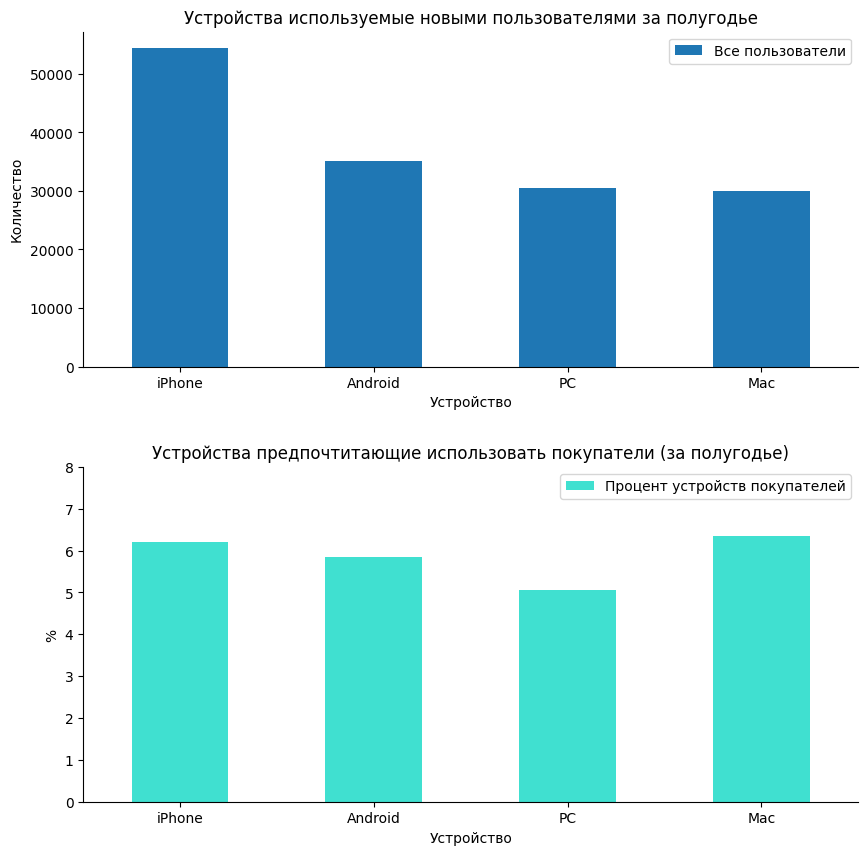

In [29]:
graph_data = (work_data.sort_values(by='user_id',ascending = False)
                       .rename(columns = {'user_id':'Все пользователи', 
                                          'payer':'Покупатели',
                                          'payer_pct':'Процент устройств покупателей'}))
fig, ax = plt.subplots(2,1, figsize = (10,10))
plt.subplots_adjust(hspace=0.3)
ax[0].set_title('Устройства используемые новыми пользователями за полугодье')
(graph_data.plot(y = 'Все пользователи', kind = 'bar', rot = 0,
              xlabel = 'Устройство', ylabel = 'Количество',
              ax = ax[0]))

ax[1].set_title('Устройства предпочтитающие использовать покупатели (за полугодье)')
(graph_data.plot(y = 'Процент устройств покупателей', kind = 'bar', rot = 0,
              xlabel = 'Устройство', ylabel = '%',
              ax = ax[1], color = 'turquoise', ylim = (0, 8)))
sns.despine()
plt.show()

In [30]:
work_data

user_id  payer  payer_pct  new_users_pct
device                                           
Android    35032   2050       5.85           23.4
Mac        30042   1912       6.36           20.0
PC         30455   1537       5.05           20.3
iPhone     54479   3382       6.21           36.3

- Меньше всего новых посетителей с Mac - 30042, но процент покупателей из них больше всего - 6.4 %.
- Больше всего новых посетителей с iPhone - 54479, а покупателей немного меньше, чем с Mac - 6.2 %.
- С Android новых посетителей и покупателей меньше, чем с iPhone - 35032 и 5.9 % соотвественно.
- С PC новых посетителей и покупателей меньше, чес с Android - 30455 и 5.1 % соотвественно.

По мобильным платформам по количеству посетителей и покупателей лидирует iPhone. На Mac чаще становятся покупателями, чем на PC, но количество новых пользователей на Mac меньше, чем на PC. Покупатели чеще предпочитают Mac и iPhone.

<a id = 'channels'></a>
### [Рекламные каналы](#plan)
Исследуем каналы привлечения пользователей - сколько пришло посетителей по каналам, и по какому каналу они стали покупателями.

In [31]:
work_data = profiles.groupby('channel').agg({'user_id':'count', 'payer':'sum'})
work_data['payer_pct'] = round(work_data['payer']/work_data['user_id']*100,2)
work_data['new_users_pct'] = round(work_data['user_id']/profiles.shape[0] * 100,1)
channels_users = work_data
channels_users.sort_values(by='payer_pct', ascending = False)

user_id  payer  payer_pct  new_users_pct
channel                                                     
FaceBoom              29144   3557      12.20           19.4
AdNonSense             3880    440      11.34            2.6
lambdaMediaAds         2149    225      10.47            1.4
TipTop                19561   1878       9.60           13.0
RocketSuperAds         4448    352       7.91            3.0
WahooNetBanner         8553    453       5.30            5.7
YRabbit                4312    165       3.83            2.9
MediaTornado           4364    156       3.57            2.9
LeapBob                8553    262       3.06            5.7
OppleCreativeMedia     8605    233       2.71            5.7
organic               56439   1160       2.06           37.6

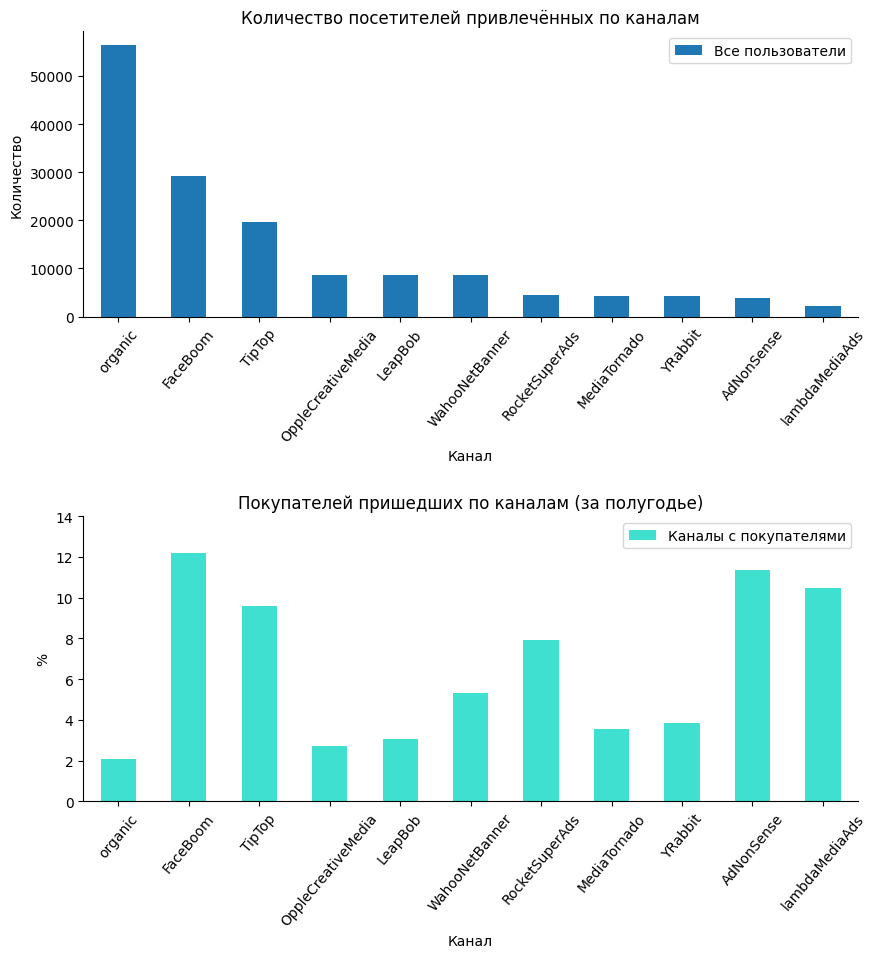

In [32]:
graph_data = (work_data.sort_values(by='user_id',ascending = False)
                       .rename(columns = {'user_id':'Все пользователи', 
                                          'payer':'Покупатели',
                                          'payer_pct':'Каналы с покупателями'}))
fig, ax = plt.subplots(2,1, figsize = (10,10))
plt.subplots_adjust(hspace=0.7)

ax[0].set_title('Количество посетителей привлечённых по каналам')
(graph_data.plot(y = 'Все пользователи', kind = 'bar', rot = 50,
              xlabel = 'Канал', ylabel = 'Количество',
              ax = ax[0]))

ax[1].set_title('Покупателей пришедших по каналам (за полугодье)')
(graph_data.plot(y = 'Каналы с покупателями', kind = 'bar', rot = 50,
              xlabel = 'Канал', ylabel = '%',
              ax = ax[1], color = 'turquoise', ylim = (0,14)))
sns.despine()
plt.show()

In [33]:
num_1 = ['первом','втором', "третьем", "четвёртом", "пятом", "шестом", "седьмом", "восьмом", "девятом", "последнем"]
num_2 = ["первый", "второй","третий","червёртый","пятый","шестой","седьмой","восьмой","девятый","последний"]

work_data = channels_users.sort_values(by='user_id', ascending = False)
work_data = work_data.loc[work_data.index != 'organic']
work_data['new_user_pos'] = range(len(work_data))
work_data = work_data.sort_values(by='payer_pct', ascending = False)
work_data['payer_pos'] = range(len(work_data))

for i in work_data.index[:10]:
    j = work_data.loc[i,'payer_pos']
    k = work_data.loc[i,'new_user_pos']
    print(f"- {i} на {num_1[j]} месте по объёму покупателей - {work_data.loc[i,'payer_pct']} % и {num_2[k]} по количеству новых посетителей - {work_data.loc[i,'user_id']}.")

- FaceBoom на первом месте по объёму покупателей - 12.2 % и первый по количеству новых посетителей - 29144.
- AdNonSense на втором месте по объёму покупателей - 11.34 % и девятый по количеству новых посетителей - 3880.
- lambdaMediaAds на третьем месте по объёму покупателей - 10.47 % и последний по количеству новых посетителей - 2149.
- TipTop на четвёртом месте по объёму покупателей - 9.6 % и второй по количеству новых посетителей - 19561.
- RocketSuperAds на пятом месте по объёму покупателей - 7.91 % и шестой по количеству новых посетителей - 4448.
- WahooNetBanner на шестом месте по объёму покупателей - 5.3 % и пятый по количеству новых посетителей - 8553.
- YRabbit на седьмом месте по объёму покупателей - 3.83 % и восьмой по количеству новых посетителей - 4312.
- MediaTornado на восьмом месте по объёму покупателей - 3.57 % и седьмой по количеству новых посетителей - 4364.
- LeapBob на девятом месте по объёму покупателей - 3.06 % и червёртый по количеству новых посетителей - 8553.
-

- Больше всего новых посетителей из кнала organic, при этом покупателей из них меньше, чем в остальных каналах - 2 %.

FaceBoom лидер по количеству покупателей и посетителей. AdNonSense, lambdaMediaAds и RocketSuperAds - маленькие каналы, но покупателями в них становтся чаще. TipTop второй по количеству новых посетителей с большим процентом покупателей. WahooNetBanner - средний по количеству новых посетителей канал, с процентом посетителей меньше, чем предидущие каналы. LeapBob и OppleCreativeMedia - средние каналы по количеству новых пользователей, но покупателями из них становяться реже. Yrabbit и MediaTornado - маленькие каналы по количеству новых пользователей и покупателями из них становяться реже.

AdNonSense, lambdaMediaAds и RocketSuperAds выглядят перспективно если будут развиваться со схожим процентом покупателей. Канал organic работает и 2 % покупателей приходят бесплатно.

<a id = 'extra_section'></a>
### [Дополнительный раздел](#plan)

**Приток новых пользователей без organic**

Построим график динамики появления новых пользователей пришедших по платным каналам (без учёта organic).

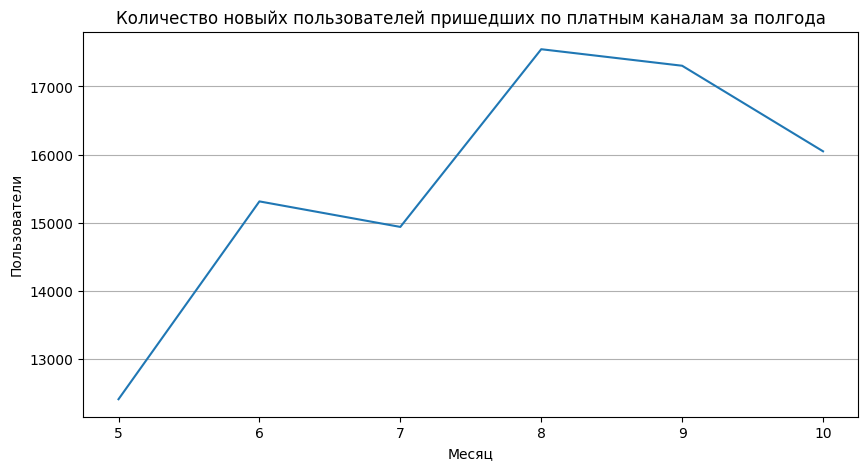

In [34]:
fig, axs = plt.subplots(figsize = (10,5))
profiles.query('channel != "organic"')['month'].value_counts().sort_index().plot(rot = 0, ax = axs,
                                      figsize = (10,5), ylabel = 'Пользователи',
                                      xlabel = 'Месяц',
                                      title = 'Количество новыйх пользователей пришедших по платным каналам за полгода')
axs.grid(axis ='y')
plt.show()

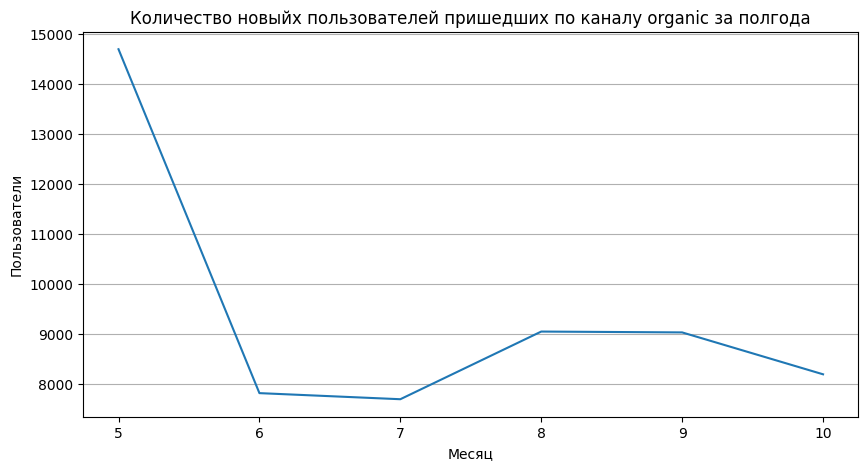

In [35]:
fig, axs = plt.subplots(figsize = (10,5))
profiles.query('channel == "organic"')['month'].value_counts().sort_index().plot(rot = 0, ax = axs,
                                      figsize = (10,5), ylabel = 'Пользователи',
                                      xlabel = 'Месяц',
                                      title = 'Количество новыйх пользователей пришедших по каналу organic за полгода')
axs.grid(axis ='y')
plt.show()

- Работали восновном платные каналы привлечения.
- Траффик из канала organic резко в июне. Возможно проблема возникала в SEO-оптимизации.

**Исследование по region & device**

Исследуем какие устройства используют новые пользователи из разных стран.

In [36]:
regions_device_rating = (profiles.groupby(['region','device'])['user_id'].count().reset_index()
                         .merge(profiles.groupby(['region'])['user_id'].count(), on =['region'])
                         .merge(profiles.groupby(['region','device'])['payer'].sum(), on =['region','device']))
regions_device_rating['payers_dev_pct'] = round((regions_device_rating['payer'] / regions_device_rating['user_id_x'])*100,2)
regions_device_rating['users_dev_pct'] = round((regions_device_rating['user_id_x'] / regions_device_rating['user_id_y'])*100,2)
regions_device_rating = regions_device_rating.drop(columns = ['user_id_y']).sort_values(by = ['region','payers_dev_pct'], ascending = False)
regions_device_rating

region   device  user_id_x  payer  payers_dev_pct  users_dev_pct
12  United States  Android      20199   1487            7.36          20.20
13  United States      Mac      24842   1706            6.87          24.84
14  United States       PC      10432    715            6.85          10.43
15  United States   iPhone      44529   2994            6.72          44.53
10             UK       PC       7138    301            4.22          40.61
8              UK  Android       5141    202            3.93          29.25
11             UK   iPhone       3518    134            3.81          20.02
9              UK      Mac       1778     63            3.54          10.12
6         Germany       PC       5945    253            4.26          39.68
4         Germany  Android       4440    182            4.10          29.64
7         Germany   iPhone       3012    120            3.98          20.11
5         Germany      Mac       1584     61            3.85          10.57
1          France      Mac       1838     82            4.46          10.53
3          France   iPhone       3420    134            3.92          19.60
2          France       PC       6940    268            3.86          39.77
0          France  Android       5252    179            3.41          30.10

- В United States рейтинг популярности устройств новых посетителей: iPhone, Mac, Android, PC.
- Рейтинг пользовательских устройств покупателей (чаще становятся покупателями) в United States: Android, Mac, PC, iPhone.
- В UK и Germany рейтинг популятоности устройств новых посетителей и покупателей одинаков: PC, Android, iPhone, Mac.
- В France рейтинг популярности устройств новых посетителей: PC, Android, iPhone, Mac.
- Рейтинг пользовательских устройств покупателей (чаще становятся покупателями) в France: Mac, iPhone, PC, Android.

**Исследование по region & channel**

Исследуем по каким каналам приходят платные пользователи из разных стран. То есть без учёта organic.

In [37]:
regions_channel_rating = (profiles.groupby(['region','channel'])['user_id'].count().reset_index()
                         .merge(profiles.groupby(['region'])['user_id'].count(), on =['region'])
                         .merge(profiles.groupby(['region','channel'])['payer'].sum(), on =['region','channel']))
regions_channel_rating['payers_dev_pct'] = round((regions_channel_rating['payer'] / regions_channel_rating['user_id_x'])*100,2)
regions_channel_rating['users_dev_pct'] = round((regions_channel_rating['user_id_x'] / regions_channel_rating['user_id_y'])*100,2)
regions_channel_rating = regions_channel_rating.drop(columns = ['user_id_y']).sort_values(by = ['region','payers_dev_pct'], ascending = False)
regions_channel_rating

region             channel  user_id_x  payer  payers_dev_pct  \
18  United States            FaceBoom      29144   3557           12.20   
21  United States              TipTop      19561   1878            9.60   
20  United States      RocketSuperAds       4448    352            7.91   
22  United States             YRabbit       4312    165            3.83   
19  United States        MediaTornado       4364    156            3.57   
23  United States             organic      38173    794            2.08   
12             UK          AdNonSense       1295    148           11.43   
16             UK      lambdaMediaAds        758     76           10.03   
15             UK      WahooNetBanner       3003    153            5.09   
13             UK             LeapBob       3046    103            3.38   
14             UK  OppleCreativeMedia       3052     89            2.92   
17             UK             organic       6421    131            2.04   
6         Germany          AdNonSense       1219    142           11.65   
10        Germany      lambdaMediaAds        649     67           10.32   
9         Germany      WahooNetBanner       2579    148            5.74   
7         Germany             LeapBob       2519     69            2.74   
8         Germany  OppleCreativeMedia       2562     64            2.50   
11        Germany             organic       5453    126            2.31   
4          France      lambdaMediaAds        742     82           11.05   
0          France          AdNonSense       1366    150           10.98   
3          France      WahooNetBanner       2971    152            5.12   
1          France             LeapBob       2988     90            3.01   
2          France  OppleCreativeMedia       2991     80            2.67   
5          France             organic       6392    109            1.71   

    users_dev_pct  
18          29.14  
21          19.56  
20           4.45  
22           4.31  
19           4.36  
23          38.17  
12           7.37  
16           4.31  
15          17.09  
13          17.33  
14          17.37  
17          36.53  
6            8.14  
10           4.33  
9           17.22  
7           16.81  
8           17.10  
11          36.40  
4            4.25  
0            7.83  
3           17.03  
1           17.12  
2           17.14  
5           36.63

- Рекламные каналы в United States (по доле покупателей и посетителей):
    * FaceBoom,
    * TipTop,
    * RocketSuperAds,
    * MediaTornado,
    * YRabbit.
- Рекламные каналы в UK, France, Germany (по доле покупателей):
    * WahooNetBanner (первый в Germany по количеству посетителей)
    * AdNonSense (четвёртый во всех странах Europe по количеству посетителей),
    * LeapBob (второй в UK и France по количеству посетителей),
    * lambdaMediaAds (на последнем месте о всех странах Europe по количеству посетителей),
    * OppleCreativeMedia (на первом месте в UK и France по количеству посетителей).
- В UK OppleCreativeMedia работала лучше по конверсии в покупателей, чем lambdaMediaAds.

<a id = 'partition_summary_1'></a>
### [Итоги раздела](#plan)

Всего новых посетителей: 94.1 % (141127).\
А покупателей: 5.9 % (8881).\
Новые пользователи привлекались в период c 2019-05-01 по 2019-10-27.

**Про страны**\
Основной приток новых посетителей и покупателей из United States (100002 посетителя, 6.9 % покупателей). В Germany посетители чаще становяться покупателями (4.1 %) по сравнению с остальными странами Europe, но количество посетителей наименьшее среди стран Europe (14981). Во France больше смотрять, чем покупают (17450 посетителей, 3.8 % покупателей). В UK посетителей больше всего из стран Europe и хороший процент покупателей (17575 посетителей, 4 % покупателей).

**Про устройства**\
В целом больше всего новых посетителей используют iPhone (54479), а покупателями стали 6.2 %. На втором месте по количеству посетителей Android (35032), покупателями стали 5.9 %. На третьем месте по количеству посетителей пользователи PC (30455), а покупателями стали 5.1 %. На последнем месте по количеству новых посетителей Mac (30042), но пользователи этой платформы чаще становятся покупателями, чем на остальных платформах - 6.4 %.

В целом по мобильным платформам по количеству посетителей и покупателей лидирует iPhone. На Mac чаще становятся покупателями, чем на PC, но количество новых пользователей на Mac меньше, чем на PC. Покупателями в цчаще становятся пользователи Mac и iPhone.

Есть предпочтения в использовании определённых устройств среди пользователей из разных стран. 
+ В United States рейтинг популярности устройств новых посетителей: iPhone, Mac, Android, PC.
+ Рейтинг пользовательских устройств покупателей (чаще становятся покупателями) в United States: Android, Mac, PC, iPhone.
+ В UK и Germany рейтинг популятоности устройств новых посетителей и покупателей одинаков: PC, Android, iPhone, Mac.
+ В France рейтинг популярности устройств новых посетителей: PC, Android, iPhone, Mac.
+ Рейтинг пользовательских устройств покупателей (чаще становятся покупателями) в France: Mac, iPhone, PC, Android.

**Про каналы**\
В целом FaceBoom лидер по количеству новых посетителей (29144) и покупателей (12.2 %). AdNonSense, lambdaMediaAds и RocketSuperAds - маленькие каналы (посетителей соотвественно: 3880, 2149, 4448), но покупателями в них становтся чаще (11.34 %, 10.47 %, 7.91 %). TipTop второй по количеству новых посетителей (29144) с большим процентом покупателей (9.6 %). WahooNetBanner - средний по количеству новых посетителей канал (8553), с процентом посетителей меньше, чем предидущие каналы (5.3 %). LeapBob и OppleCreativeMedia - средние каналы по количеству новых посетителей (8553 и 8605), но покупателями из них становяться реже (3.06 % и 2.71 %). Yrabbit и MediaTornado - маленькие каналы по количеству новых посетителей (4312 и 4364). И покупателями из них становяться реже (3.83 % и 3.57 % соотвественно).

В разных странах используются разные каналы - есть чёткое разделение на регионы US и EU.
- Рекламные каналы в United States (в порядке убывания доли покупателей и посетителей):
    * FaceBoom,
    * TipTop,
    * RocketSuperAds,
    * MediaTornado,
    * YRabbit.
- Рекламные каналы в UK, France, Germany (в порядке рейтинга по доле покупателей в каждой стране):
    * WahooNetBanner (первый в Germany по количеству посетителей и третий в UK и France),
    * AdNonSense (четвёртый во всех странах Europe по количеству посетителей),
    * LeapBob (второй в UK и France, и третий в Germany по количеству посетителей),
    * lambdaMediaAds (на последнем месте о всех странах Europe по количеству посетителей),
    * OppleCreativeMedia (на первом месте в UK и France по количеству посетителей и второй в Germany).
- В UK OppleCreativeMedia работала лучше по конверсии в покупателей, чем lambdaMediaAds.

В United States каналы FaceBoom и TipTop наибольшие по количеству новых пользователей (29144 и 19561) и покупателей (12.2 % и 9.6 %). RocketSuperAds в сравнении с ними - небольшой канал по количеству новых пользователей (4448), но с высоким уровнем покупателей (7.91 %). Каналы YRabbit и MediaTornado тоже не большие каналы, сопостовимые по количеству новых пользователей (4312 и 4364) с RocketSuperAds. При этом покупателей они привели меньше - соотвественно 3.83 % и 3.57 %. В United States большой органический траффик - 38173 посетителей, а покупателей 2.08 %.

В UK наибольший поток новых посетителей пришло по каналам OppleCreativeMedia, LeapBob и WahooNetBanner - 3052, 3046 и 3003 посетителя соотвественно. При этом покупателями стали - 2.92 %, 3.38 %, 5.09 % соотвественно. AdNonSense и lambdaMediaAds - более мелкие каналы по притоку новых пользователей: 1295 и 758. Но покупателями там становились чаще: 11.43 % и 10.03 % соотвественно. Количество органических пользователей: 6421. А покупателями стало 2.04 %. 

В Germany схожее распределение каналов по количеству новых пользователей: крупные каналы - OppleCreativeMedia (2562), LeapBob (2519) и WahooNetBanner (2579). При этом покупателями стали соотвественно: 2.50 %, 2.74 %, 5.74 %. AdNonSense и lambdaMediaAds - более мелкие каналы по притоку новых пользователей: 1219 и 649. Но покупателями там становились чаще: 11.65 % и 10.32 % соотвественно. Количество органических пользователей: 5453. А покупателями стало 2.31 %. 

Во France наибольший поток новых посетителей так же по каналам OppleCreativeMedia (2991), LeapBob (2988) и WahooNetBanner (2971). Покупателями в них становились соотвественно: 2.67 %, 3.01 %, 5.12 %. AdNonSense и lambdaMediaAds - более мелкие каналы по притоку новых пользователей: 1366 и 742. Но покупателями там становились чаще: 10.98 % и 11.05 % соотвественно. Количество органических пользователей: 6392. А покупателями стало 1.71 %.

По конверсии посетителей в покупатели в целом выглядят перспективно RocketSuperAds.

<a id = 'payment'></a>
## [Маркетинг и расходы](#plan)

Подсчитаем общую сумму расходов за весь период, расходы на каждый источник привлечения и среднюю стоимость каждого нового пользователя (CAC).

In [38]:
channels_users = (channels_users.merge(profiles.loc[profiles['channel'] != 'organic']
                                               .groupby('channel')
                                               .agg({'acquisition_cost':'mean'}),
                                        on = 'channel')
                                .merge(costs.groupby('channel').agg({"costs":"sum"}),
                                        on = 'channel')
                                .rename(columns = {"acquisition_cost":"cac"}))
channels_users['costs_total_pct'] = round(channels_users['costs'] / costs['costs'].sum() * 100, 2)
for i in channels_users.index:
    if i in ['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit']:
        channels_users.loc[i,'region'] = 'US'
    else:
        channels_users.loc[i,'region'] = 'EU'

display(channels_users.sort_values(by = 'cac', ascending=False),
        f"Общая сумма рассходов составила: {round(costs['costs'].sum(),2)}")

user_id  payer  payer_pct  new_users_pct       cac  \
channel                                                                  
TipTop                19561   1878       9.60           13.0  2.799003   
FaceBoom              29144   3557      12.20           19.4  1.113286   
AdNonSense             3880    440      11.34            2.6  1.008054   
lambdaMediaAds         2149    225      10.47            1.4  0.724802   
WahooNetBanner         8553    453       5.30            5.7  0.602245   
RocketSuperAds         4448    352       7.91            3.0  0.412095   
OppleCreativeMedia     8605    233       2.71            5.7  0.250000   
YRabbit                4312    165       3.83            2.9  0.218975   
MediaTornado           4364    156       3.57            2.9  0.218717   
LeapBob                8553    262       3.06            5.7  0.210172   

                       costs  costs_total_pct region  
channel                                               
TipTop              54751.30            51.90     US  
FaceBoom            32445.60            30.75     US  
AdNonSense           3911.25             3.71     EU  
lambdaMediaAds       1557.60             1.48     EU  
WahooNetBanner       5151.00             4.88     EU  
RocketSuperAds       1833.00             1.74     US  
OppleCreativeMedia   2151.25             2.04     EU  
YRabbit               944.22             0.90     US  
MediaTornado          954.48             0.90     US  
LeapBob              1797.60             1.70     EU

'Общая сумма рассходов составила: 105497.3'

- 82.65 %  инвестиций пришлось на популярны каналы в United States - TipTop (54751.3) и FaceBoom (32445.6).
- Средняя стоимость каждого нового пользователя по каналу TipTop заметно выше, чем у всех остальных - 2.79.
- Высокий CAC у крупного канала FaceBoom (1.11) и небольшого канала AdNonSense (1).

Построим график динамики изменения расходов во времени по неделям и по месяцам по каждому источнику.

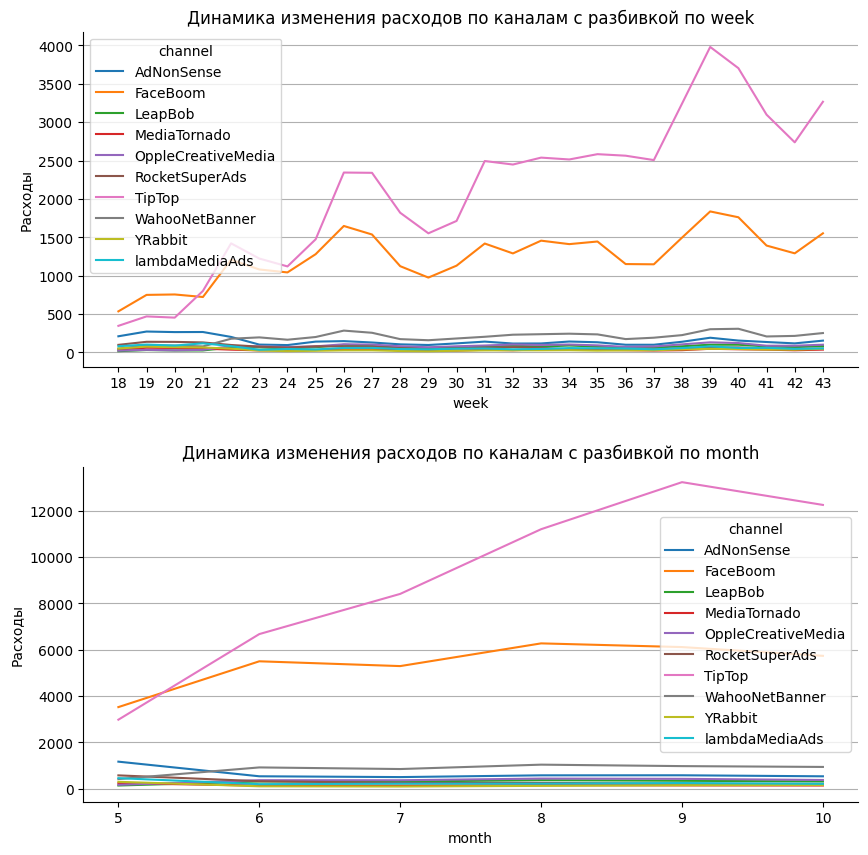

In [39]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week #добавим столбец week
fig, ax = plt.subplots(2,1, figsize = (10,10))
plt.subplots_adjust(hspace=0.3)
for i, idx in enumerate(['week','month']):
    graph_data = costs.pivot_table(index = idx, 
                      columns = 'channel', 
                      values = 'costs', 
                      aggfunc = 'sum')
    graph_data.plot(ax = ax[i], ylabel = 'Расходы')
    ax[i].set_title(f'Динамика изменения расходов по каналам с разбивкой по {idx}')
    ax[i].set_xticks(list(graph_data.index))
    ax[i].grid(True, axis = 'y')
sns.despine()
plt.show()

- Расходы по каналу TipTop каждый месяц стабильно увеличивались в течении всего периода и на порядок выше всех остальных каналов.
- расходы по каналу FaceBoom так же заметно выше большенства, но расходы увеличились не на много и в целом находились в стабильно не широком диапазоне.
- Расходы по остальным каналам были небольшие и находились в узком коридоре. 

Посмотрим были ли изменения расходов на привлечение одного нового посетителя с разбивкой по неделям и месяцам.

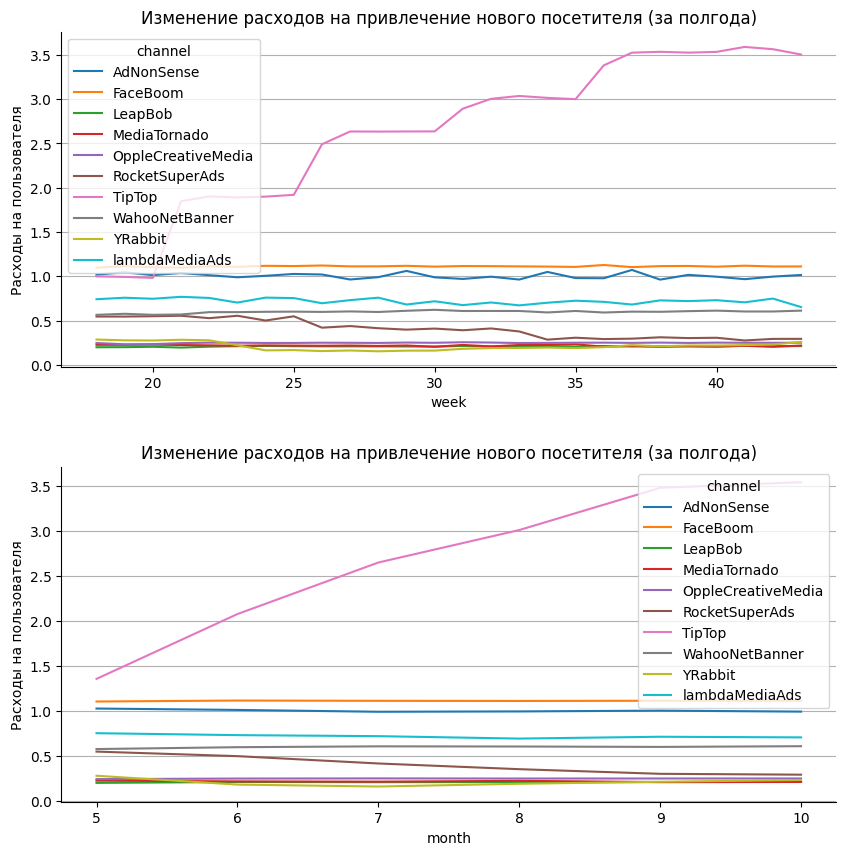

In [40]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week
fig, ax = plt.subplots(2,1, figsize = (10,10))
plt.subplots_adjust(hspace=0.3)
for i, idx in enumerate(['week', 'month']):
    work_data = (costs.groupby(['channel', idx])
                      .agg({'costs':'sum'})
                 .merge(profiles.groupby(['channel', idx])
                      .agg({'user_id':'count'}),
                  on = ['channel', idx]))
    work_data['a_costs'] = work_data['costs']/work_data['user_id']
    graph_data = work_data.pivot_table(index = idx,
                                       columns = 'channel',
                                       values = 'a_costs',
                                       aggfunc = 'max')
    graph_data.plot(ax = ax[i], title = 'Изменение расходов на привлечение нового посетителя (за полгода)',
               ylabel = 'Расходы на пользователя', xlabel = idx)
    ax[i].grid(True, axis = 'y')
sns.despine()
plt.show()

- Тариф TipTop на привлечение одного нового пользователя ступенчато рос на протяжении всего периода с интервалом между ростом в 5 недель.
- Тариф у RocketSuperAds снижался на протяжении всего периода.
- Тарифы у остальных каналов оставались стабильными или изменения были незначительные.

**Итого**\
Общая сумма инвестиций составила: 105497.3.\

За весь период 82.65 % инвестиций пришлось на популярны каналы в United States - TipTop (54751.3) и FaceBoom (32445.6). При том, что итоговый САС этих каналов - самый большой. У TipTop он на порядок выше, чем у FaceBoom. У AdNonSense САС близок к FaceBoom.\
В динамике САС у канала TipTop ступенчато рос на протяжении всего периода с интервалом в 5 недель. А у RocketSuperAds он ненамного снижался на протяжении всего периода. У остальных каналов САС был стабилен или с незначительными изменениями.

RocketSuperAds выглядит перспективным каналом.

<a id = 'overpayment'></a>
## [Оценка окупаемости](#plan)

Затраты по каналу organic отсуствуют и этот канал не будет учавствовать в дальнейшем исследовании. Информации о затратах на SEO отсутствуют.

Момент анализа - 01.11.2019.\
Горизонт анализа - 14 дней.

In [41]:
ads_profiles = profiles.query('channel != "organic"') #исключаем профили с каналом organic
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

<a id = 'score_overview'></a>
### [Общая оценка окупаемости](#plan)

Общий анализ LTV, CAC и ROI.
Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI и проведём анализ.

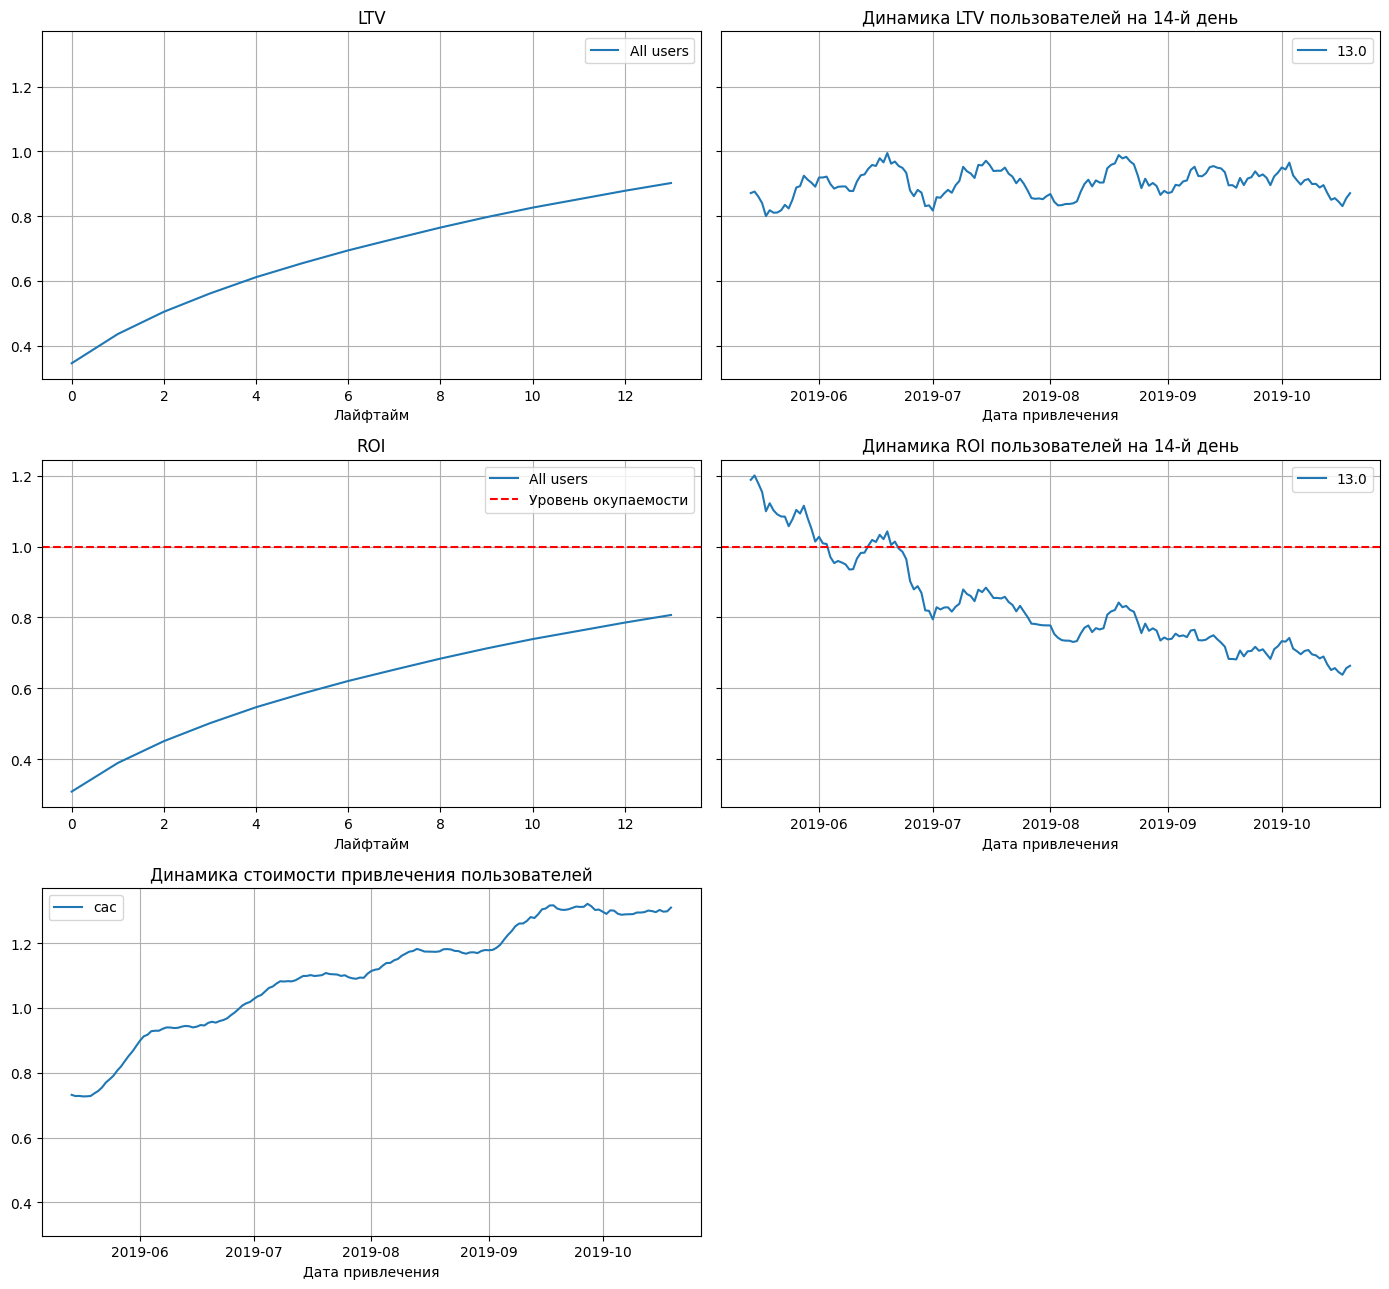

In [42]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ads_profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 14)

*Rolling window: 14*
- Общий САС ростёт на протяжении всего периода (вероятно из-за TipTop) и с июня превышает двунедельный LTV.
- 14-дневные когорты перестали окупатся в начале июня.
- 14-дневный LTV находится в стабильном коридоре.

Из за роста САС и его превышения выше LTV перестали окупатся инвестиции.

<a id = 'conversion'></a>
### [Конверсия](#plan)
Построим график общей конверсии и динамики её изменения.

In [43]:
def heatmap_conv ():
    plt.figure(figsize=(13, 5))
    sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%', cmap = "coolwarm")
    plt.xlabel('lifetime')
    plt.title('Тепловая карта конверсии')
    plt.show()

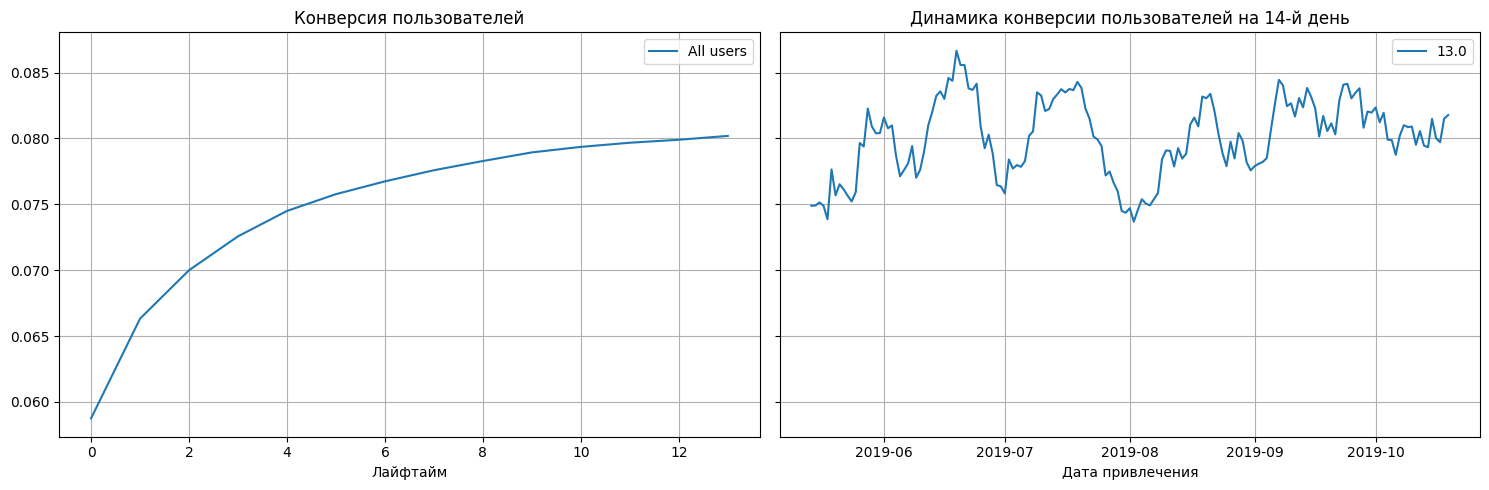

In [44]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ads_profiles, orders, observation_date, horizon_days)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14)

*Rolling window: 14*
- Общая динамика 14-невной конверсии находилась в стабильном коридоре в пределах 7.5 % и 8.5 %.
- Конверсия когорт на конец лайфтайма - 8 %.

Посмотрим конверсию с разбивкой по странам, странам и устройствам, странам и каналам.

**Конверсия по странам**

Построим тепловую карту и графики конверсии и её динамики по старнам.

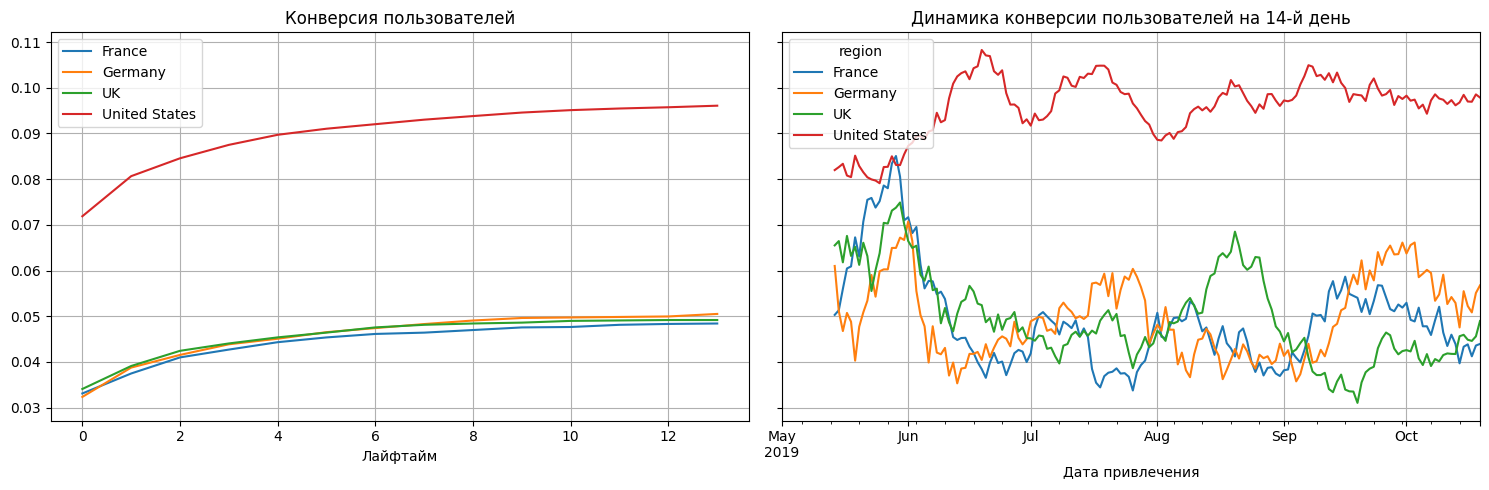

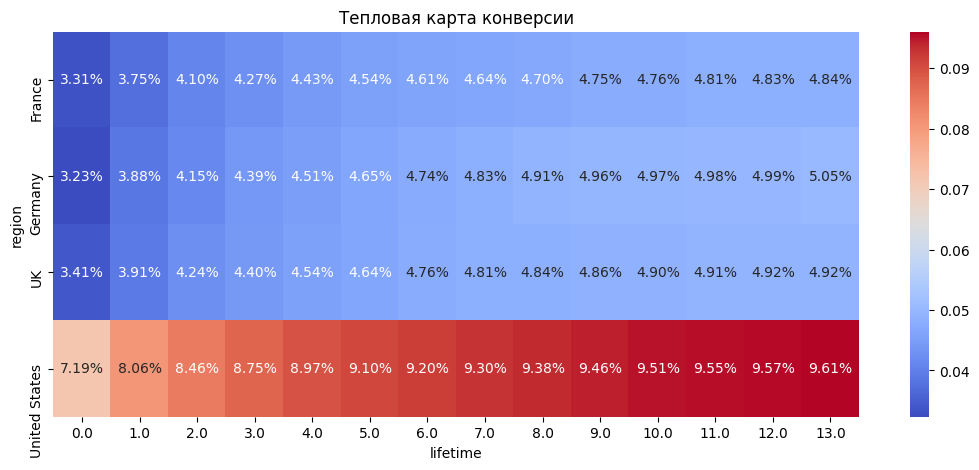

In [45]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ads_profiles, orders, observation_date, horizon_days, ['region'])
plot_conversion(conversion_grouped, conversion_history, horizon_days, window =14)
heatmap_conv()

*Rolling window: 14*
- 14-дневная конверсия в United States почти в 2 раза выше, чем в странах Europe. И с июня динамика находиться на стабильно высоком уровне в диапазоне 9 - 10.5 %.
- 14-дневная конверсия в странах Europe в целом схожая и на конец лайфтайма - около 5 %.
- Динамика конверсии в странах Europe в июне снизилась и находилась в широком диапазоне (были взлёты и падения каждый месяц): 3.5 - 6 %.

Построим график конверсии по странам и по устройствам.

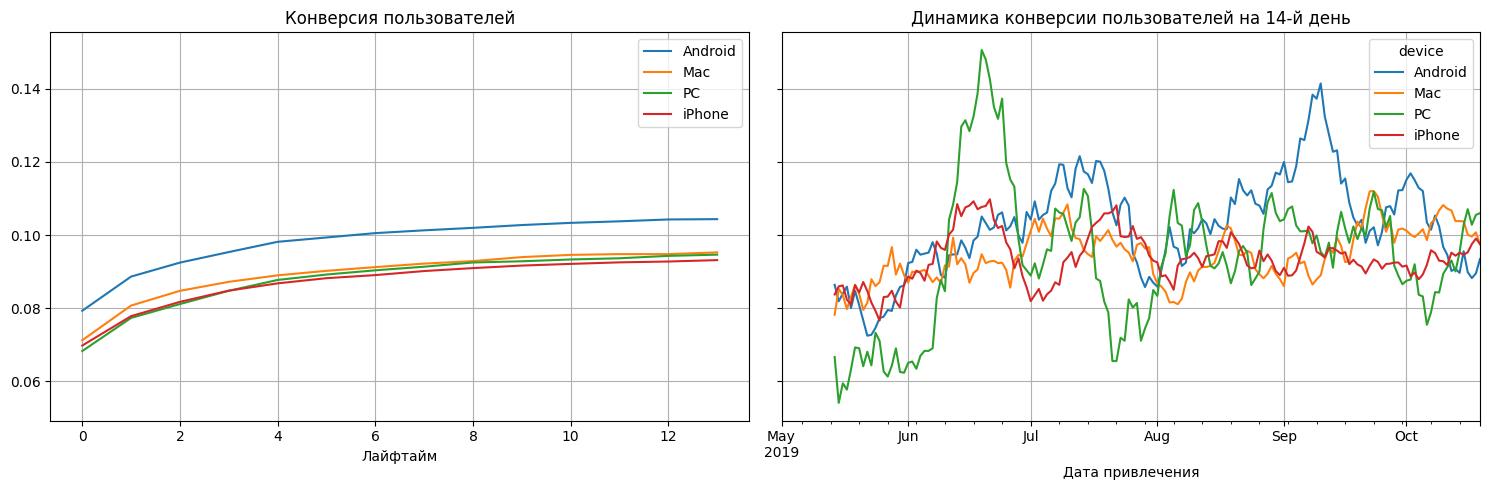

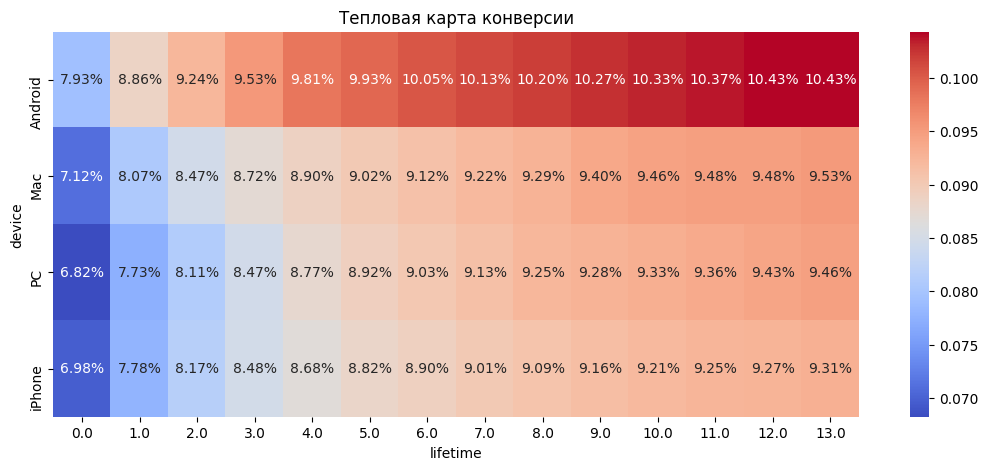

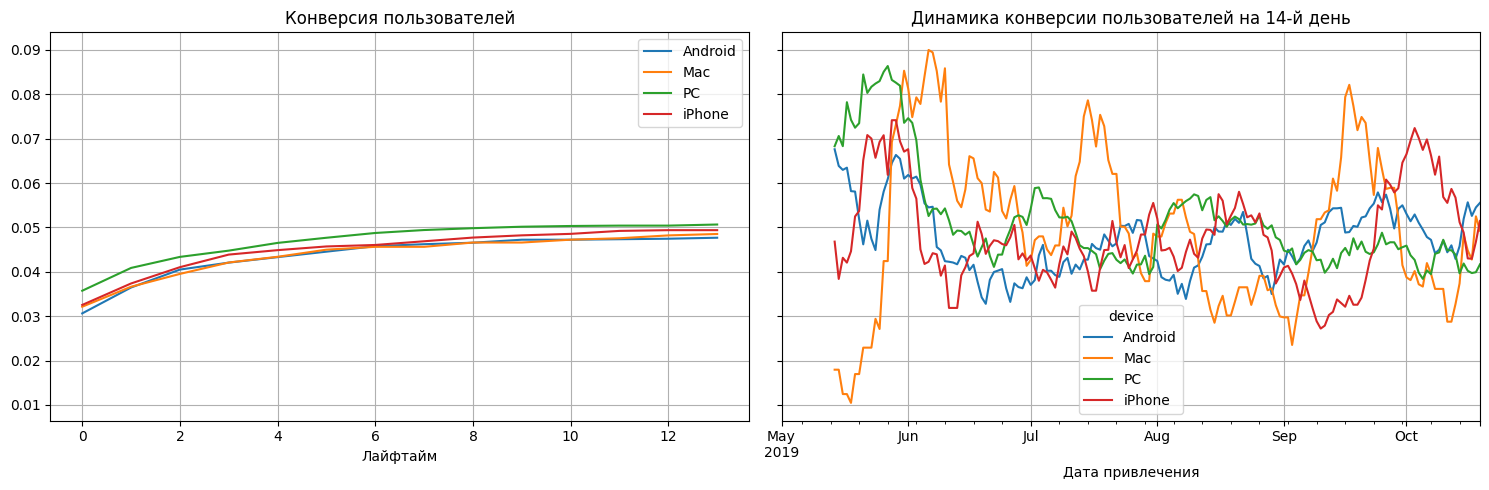

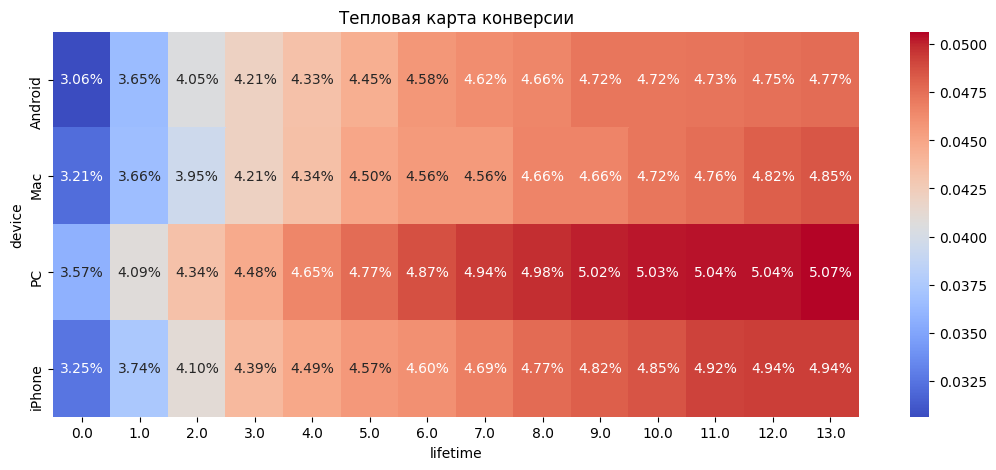

In [46]:
for i in ['United States', ['UK','France','Germany']]:
    conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ads_profiles.query('region in @i'), orders, observation_date, horizon_days, ['device'])
    display(HTML(f'<center><span style="color: black; font-size: 2em">Графики конверсии по устройствам в {i}</span> </center>'))
    plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14)
    heatmap_conv ()

*Rolling window: 14*
- Конверсия двунедельных когорт в United States распределилась в порядке (рейтинг): Android, Mac, PC, iPhone. На Android заметно выше остальных - 10.5 % в конце лайфтайма.
- Динамика двунедельной конверсии когорт в United States находиться в стабильном коридоре у Mac и iPhone, и в целом более стабильна. На Android и PC она менее стабильна - есть как взлёты, так и падения.
- Конверсия двунедельных когорт в странах Europe распределилась в порядке (рейтинг): PC, iPhone, Mac, Android. На PC немного выше остальных.
- Динамика двунедельной конверсии когорт в странах Europe находиться в более стабильном коридоре у Android и PC, и в целом более стабильна. На Mac и iPhone она менее стабильна - есть как взлёты, так и падения.

Построим график конверсии по регионам и по каналам.

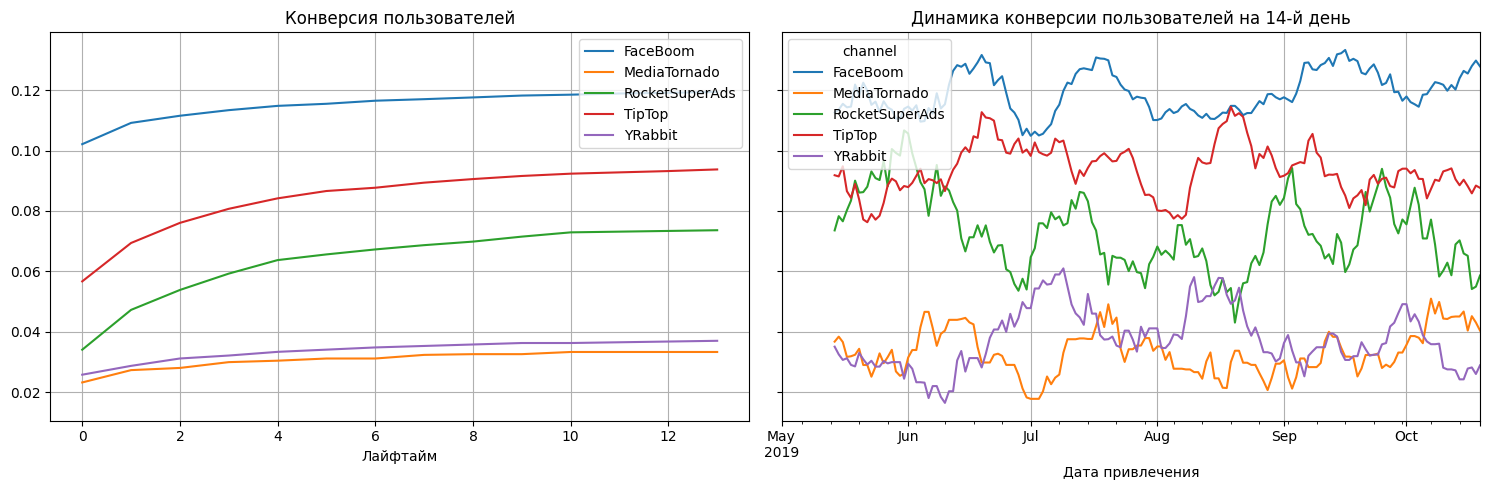

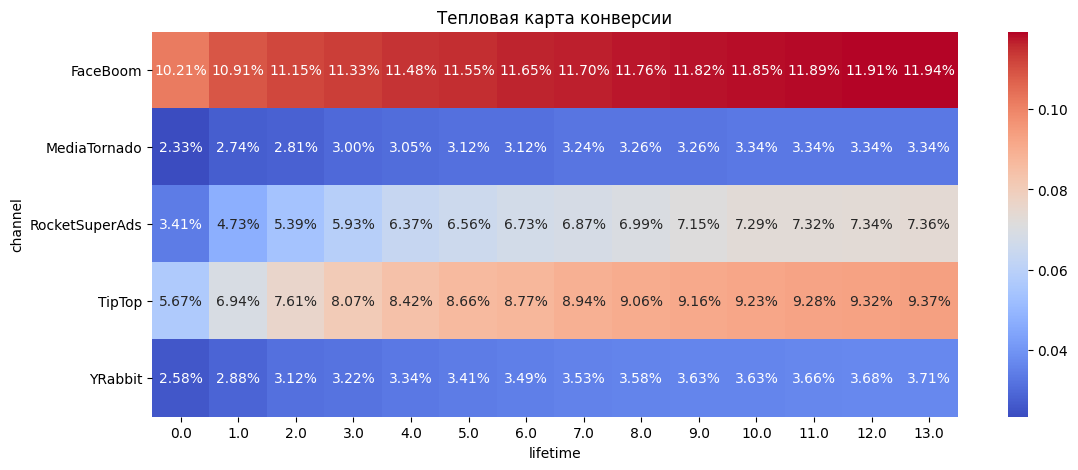

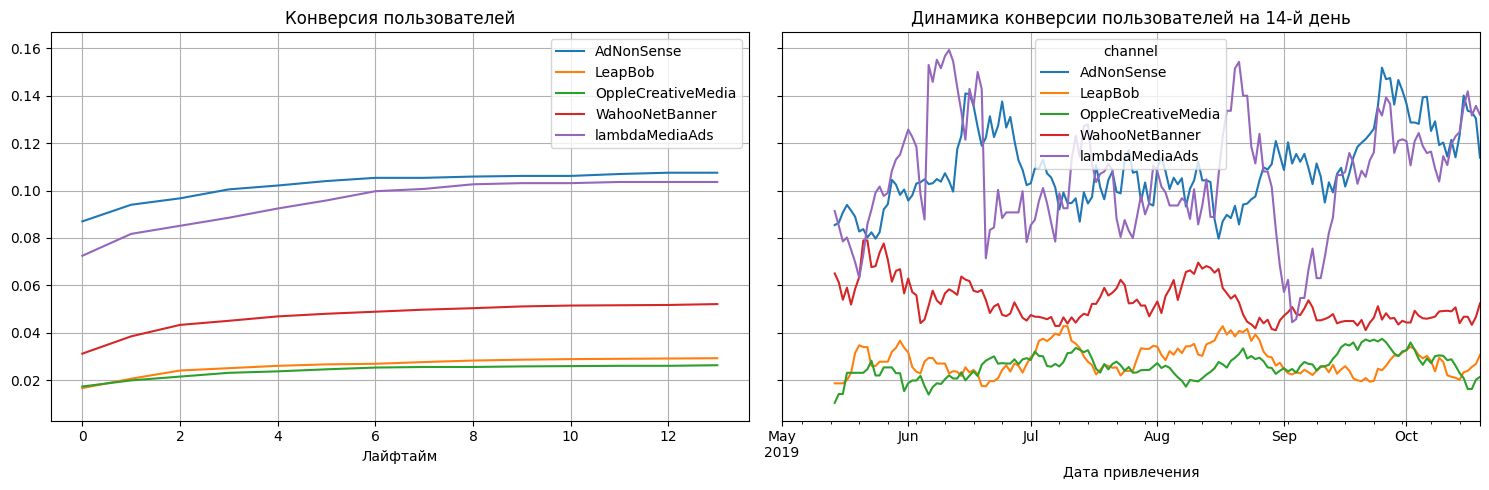

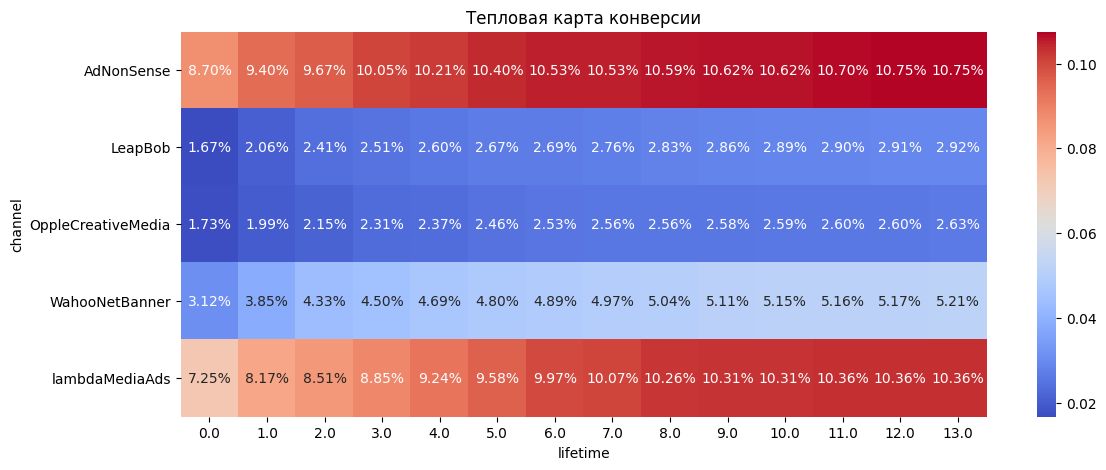

In [47]:
for i in ['United States', ['UK','France','Germany']]:
    conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ads_profiles.query('region in @i'), orders, observation_date, horizon_days, ['channel'])
    display(HTML(f'<center><span style="color: black; font-size: 2em">Графики конверсии по каналам в {i}</span> </center>'))
    plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14)
    heatmap_conv ()

*Rolling window: 14*
- Конверсия двунедельных когорт каналов в United States распределена в порядке (от большей к меньшей): FaceBoom (11.9 % на конце лайфтайма), TipTop (9.4 %), RocketSuperAds (7.3 %) и YRabbit (3.7 %), MediaTornado (3.3 %). Самая высокая у FaceBoom, TipTop и RocketSuperAds.
- Динамика двунедельной конверсии когорт по всем каналам в United States достатьчно стабильна. У FaceBoom в среднем в коридоре 10 - 13 %, у TipTop в коридоре 8 - 11 %, у RocketSuperAds в среднем 6 - 8 %, YRabbit 3 - 5 %, MediaTornado 2 - 4 %.
- Конверсия двунедельных когорт каналов в странах Europe распределена в порядке (от большей к меньшей): AdNonSence (10.8 % на конце лайфтайма), lambdaMediaAds (10.4 %), WahooNetBanner (5.2 %), LeapBob (2.9 %), OppleCreativeMedia (2.6 %). Самая высокая у AdNonSence и lambdaMediaAds.
- Динамика двунедельной конверсии когорт в странах Europe стабильна и находиться в среднем в коридоре у каналов: WahooNetBanner 4 - 6 %, LeapBob 2 - 4 %, OppleCreativeMedia 2 - 3.7 %. У AdNonSence динамика менее стабильна и имеет взлёты до 14 % и падения до 8%. У канала lambdaMediaAds она не стабильная: резкие взлёты до 16 % сменяються падениями вплоть до 4 %.

Каналы AdNonSence и lambdaMediaAds, несмотря на высокие показатели двунедельной конверсии, менее стабильны.

<a id = 'retention'></a>
### [Удержание](#plan)

Retention Rate. Построим график общего удержания и динамики удержания. 

In [48]:
def heatmap_rr():
    plt.figure(figsize = (15, 6))  # задаём размер графика
    sns.heatmap(retention_grouped.drop(columns = ['cohort_size',0]), # удаляем размеры когорт
            annot = True,  # включаем подписи
            fmt = '.2%',  # отображаем значения в виде процентов
            cmap = "coolwarm")
    plt.title('Тепловая карта удержания')  # название графика
    plt.xlabel('Lifetime')
    plt.show()

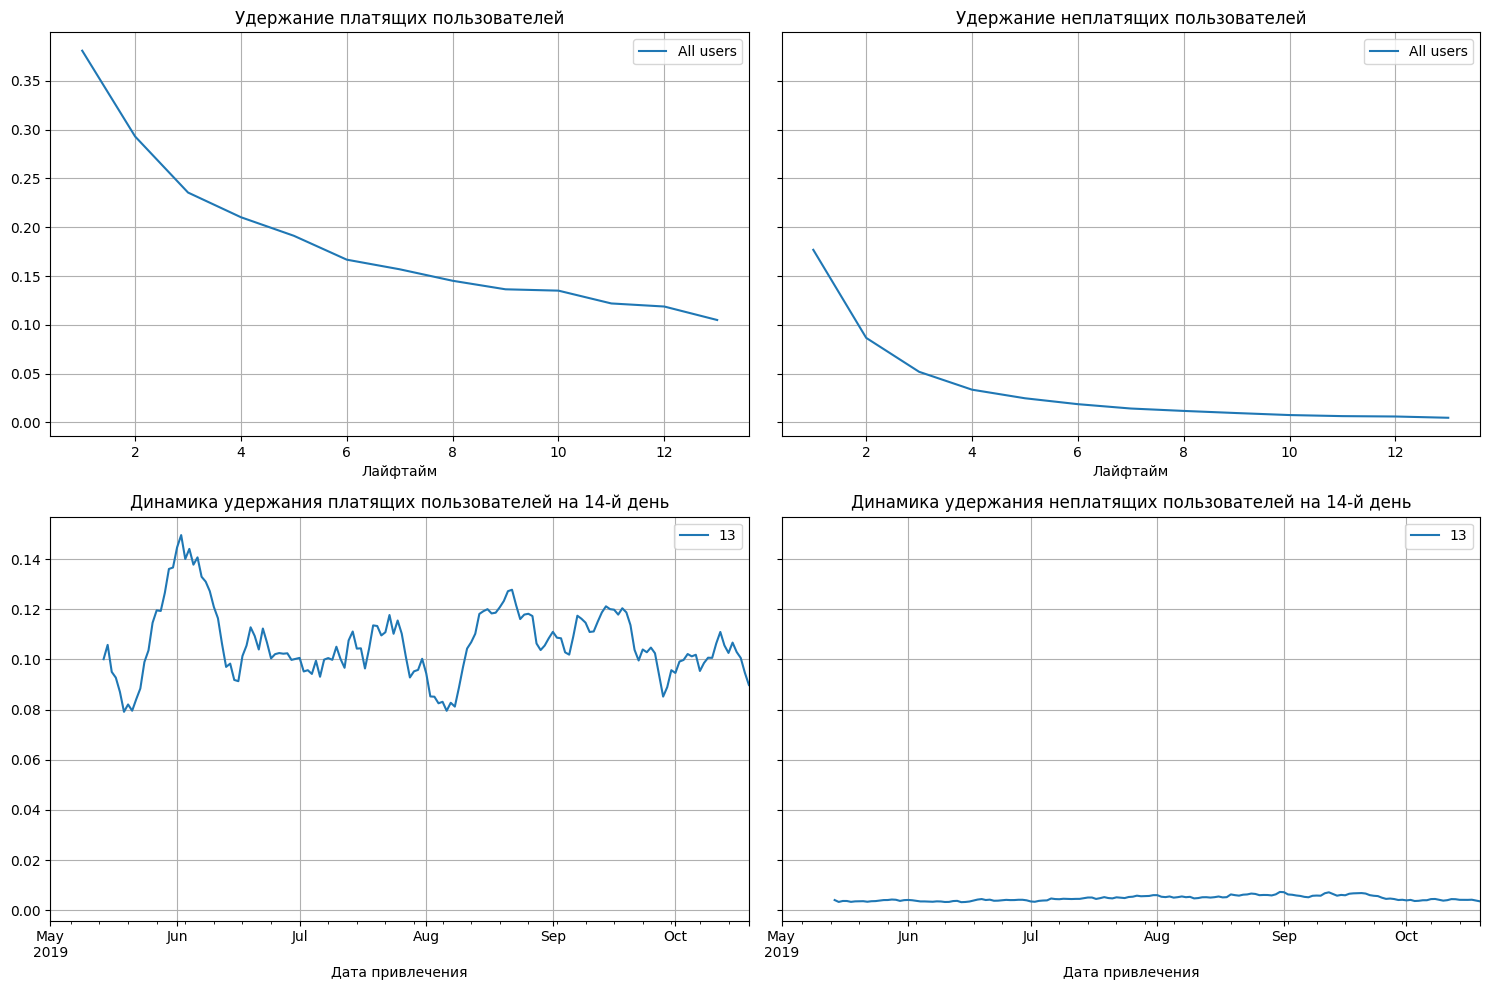

In [49]:
retention_raw, retention_grouped, retention_history = get_retention(
    ads_profiles, visits, observation_date, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days, window = 14)

*Rolling window: 14*
- Когорты покупателей в целом удерживаються лучше и дольше в двунедельный период 10 % на конец лайфтайма.
- Динамика удержания когорт платящих пользователей (окно - 14) в среднем находиться в коридоре 8 - 12 % с взлётом до 14 % в начале июня. Ни разу не опускалась ниже 5%.
- Когорты посетителей ожидаемо удерживаются хуже и их динамика удержания так же находиться около 0.

Построим график с разбивкой по устройствам.

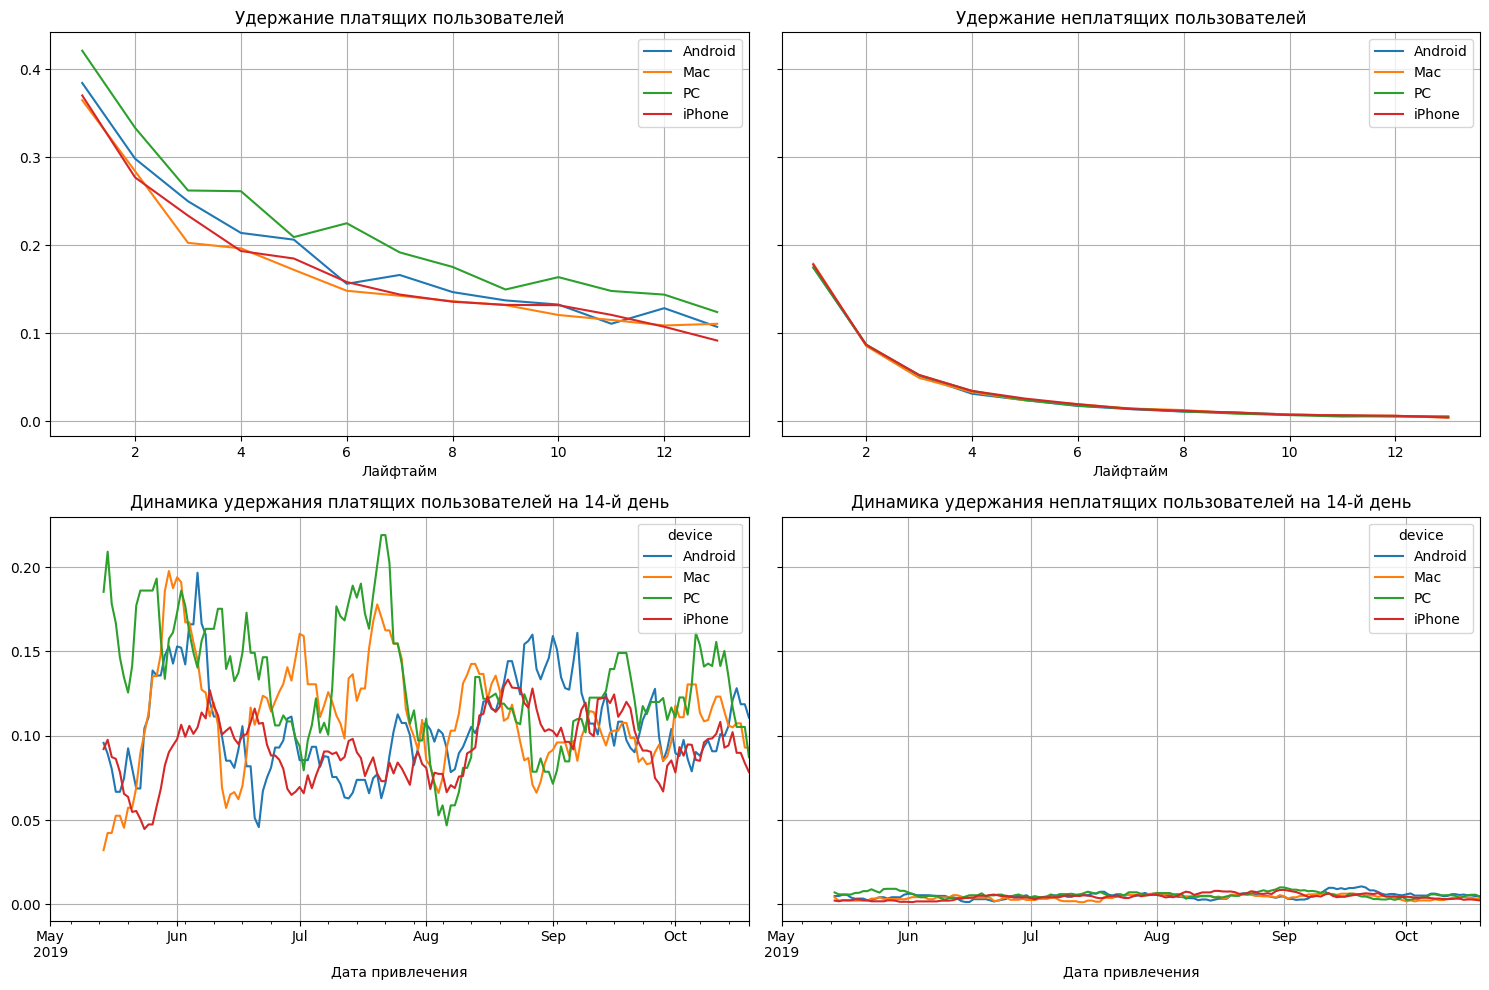

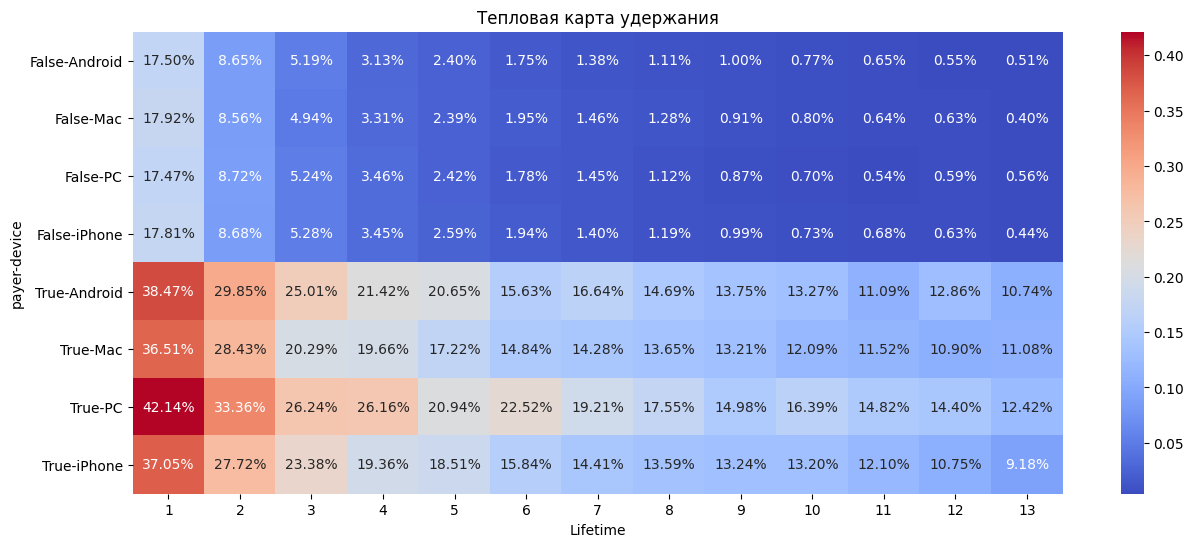

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    ads_profiles, visits, observation_date, horizon_days,['device'])
plot_retention(retention_grouped, retention_history, horizon_days, window =14)
heatmap_rr()

*Rolling window: 14*

- Когорты покупателей - пользователей PC - в целом удерживаються лучше остальных. Но коридор динамики в среднем - широк: 5 - 20 %.
- Удержание когорт покупателей ожидаемо выше посетителей.
- Широкие коридоры динамики у пользователей когорт покупателей всех платформ - есть как резкие взлёты, так и падения. Больее стабильные когорты на iPhone.

Построим график удержания пользователей по странам.

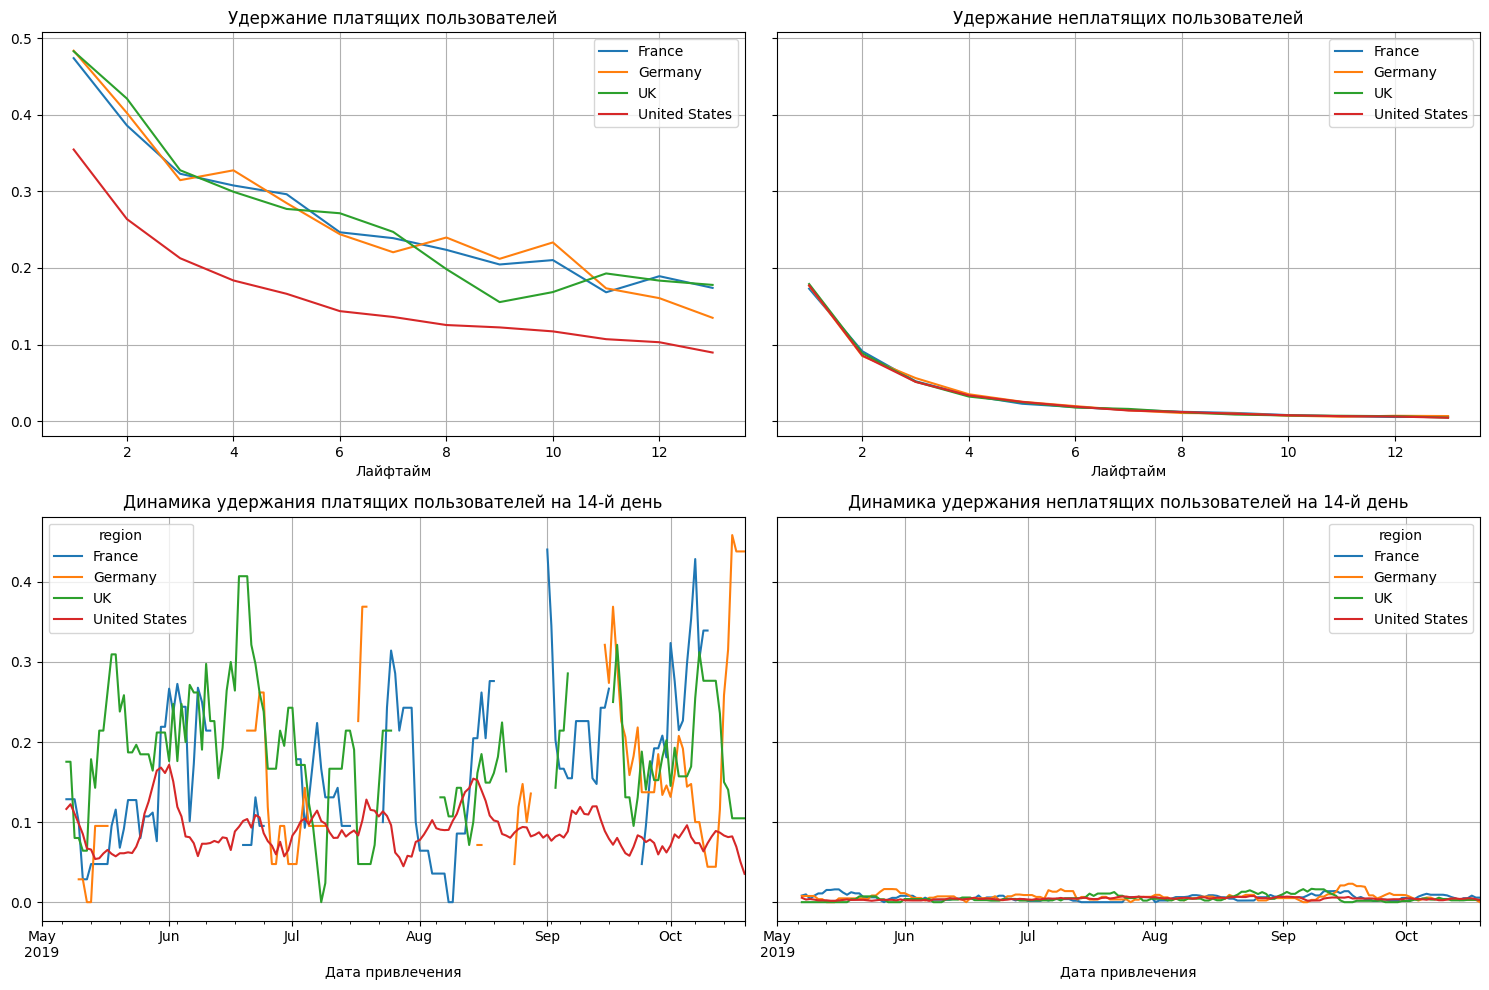

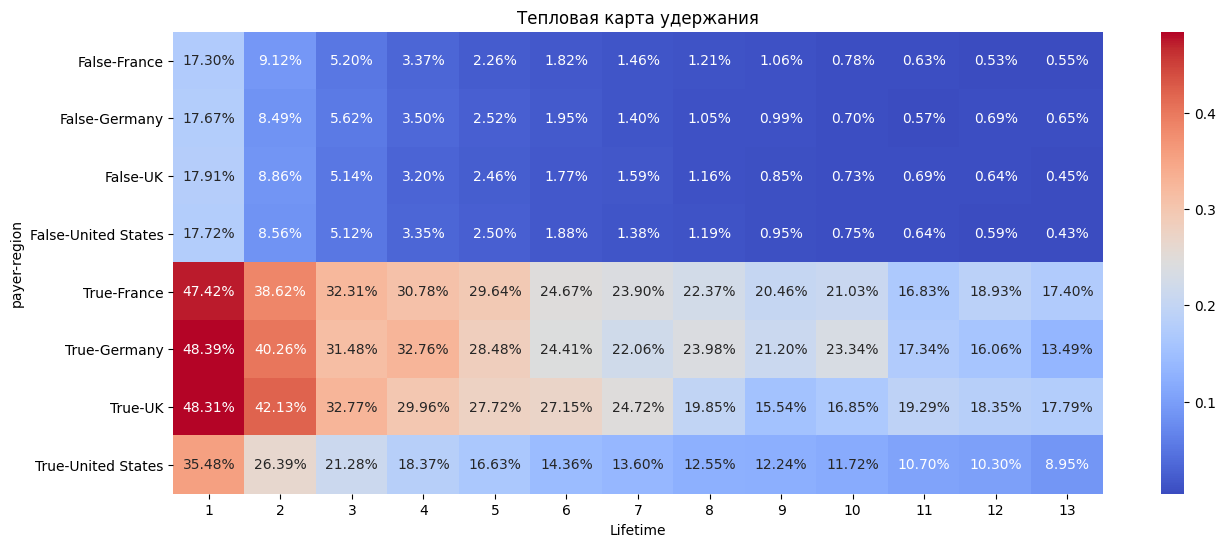

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    ads_profiles, visits, observation_date, horizon_days,['region'])
plot_retention(retention_grouped, retention_history, horizon_days, window = 7)
heatmap_rr()

*Rolling window: 7*
- Удержание когорт платящих пользователей в United States знаметно ниже (10% на), чем в странах Europe.
- Удержание когорт неплатящих пользователей ожидаемо ниже.
- Динамика удержания в United States стабильна и находиться в пределах 5 - 20 %.
- Динамика стран Europe - слишком шумная и данных не хватает для построения непрерывных линий. Поток покупателей не стабильный.

Вероятно проблема с удержанием платящих пользователей в United States.

Построим графики удержания по каналам с разбивкой по регионам.

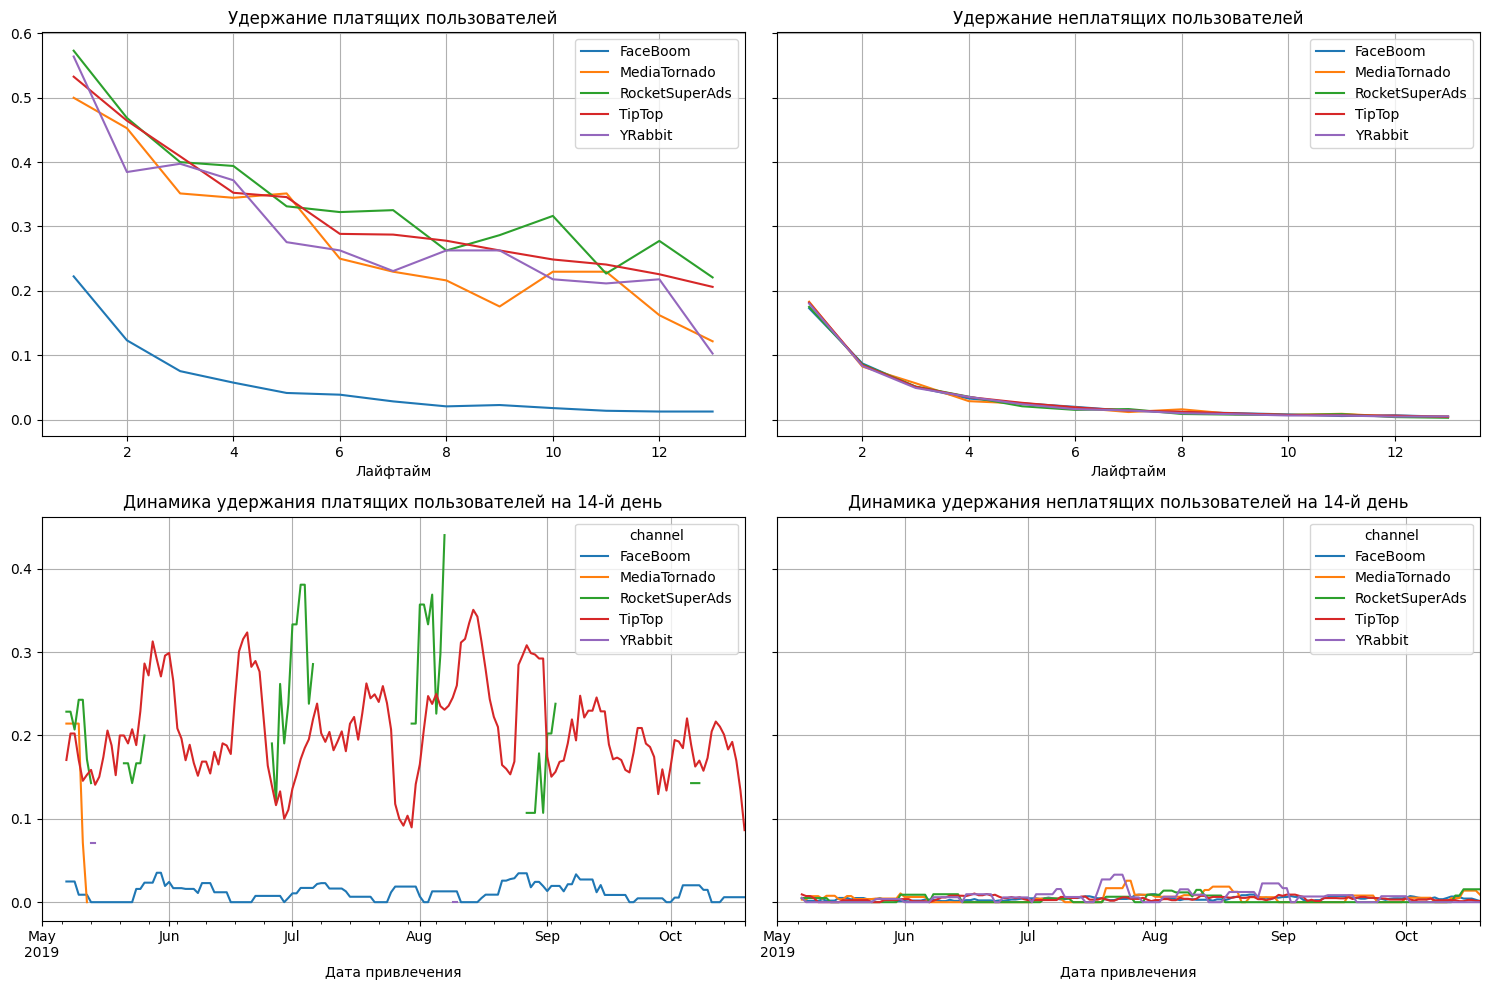

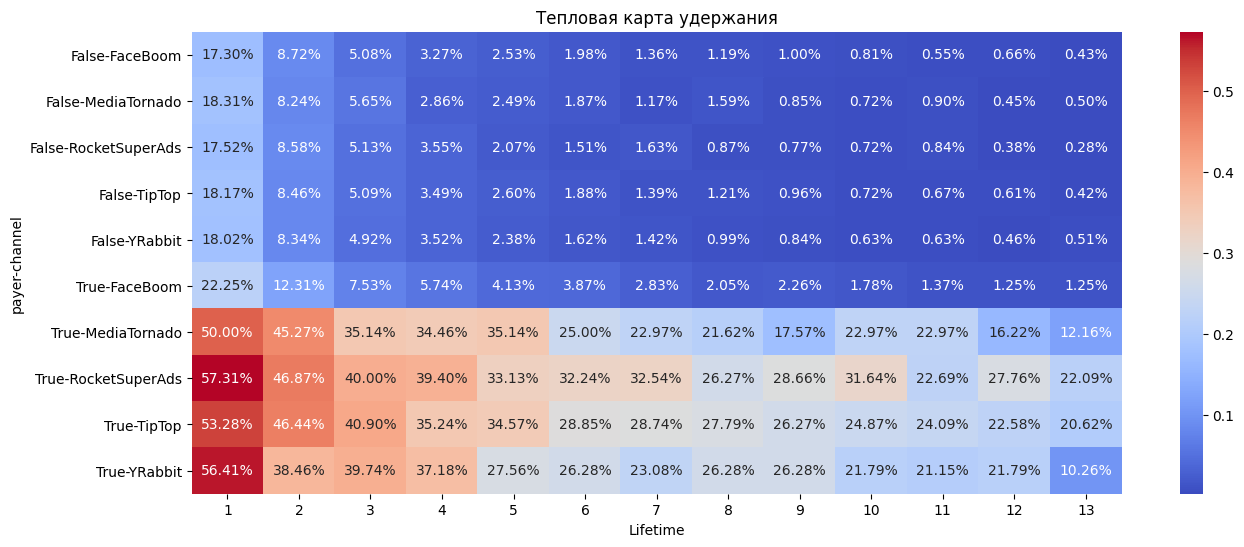

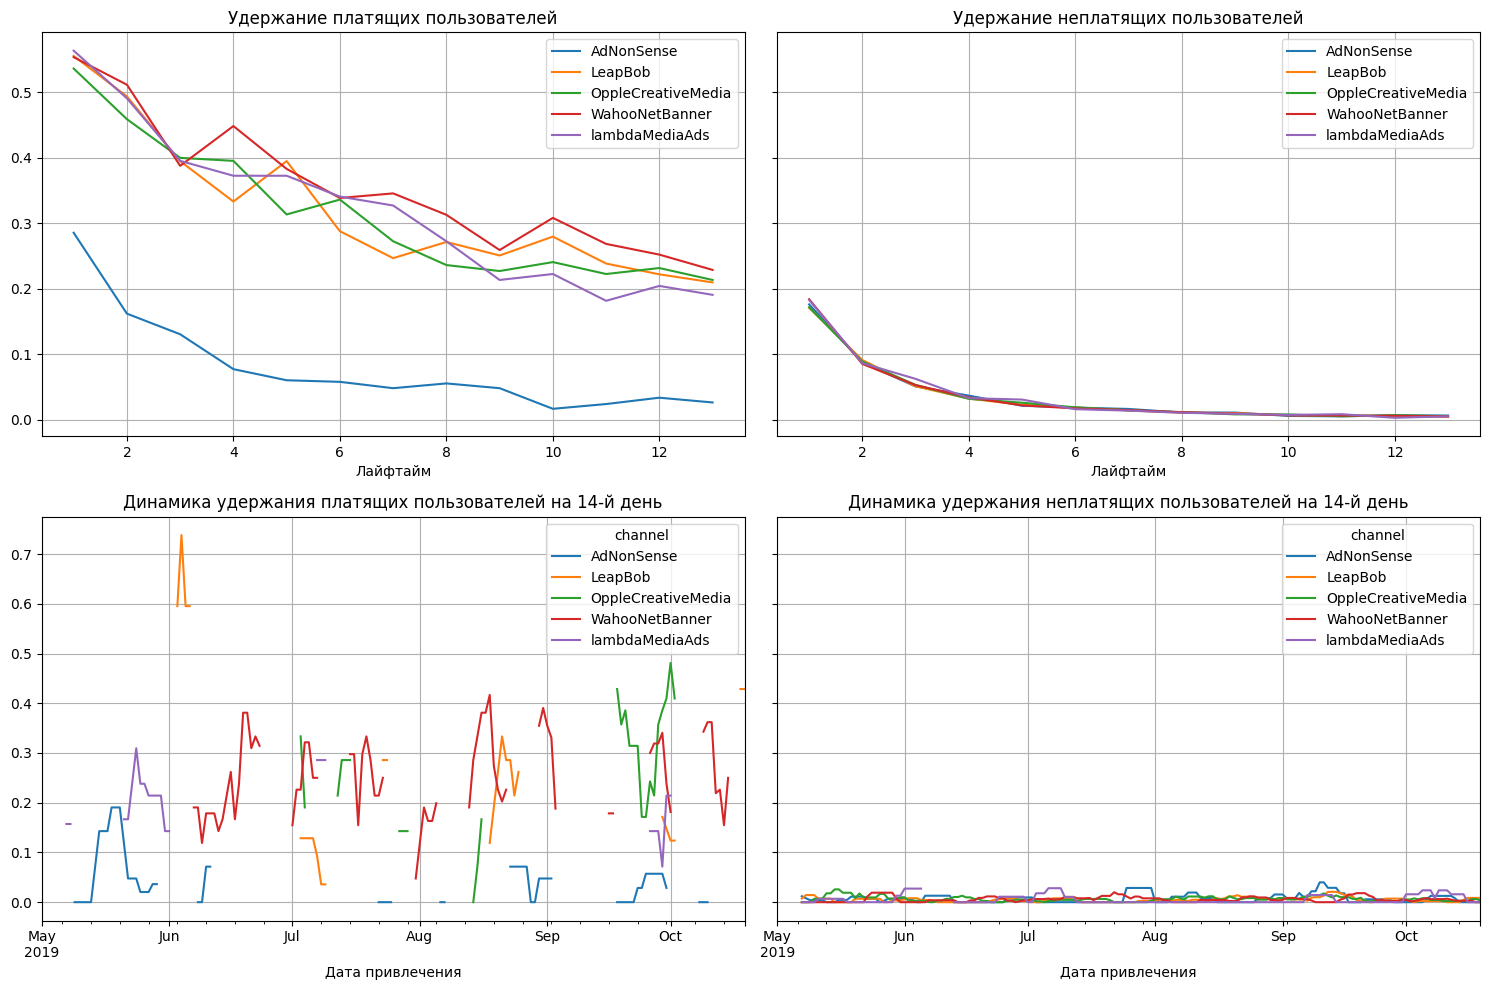

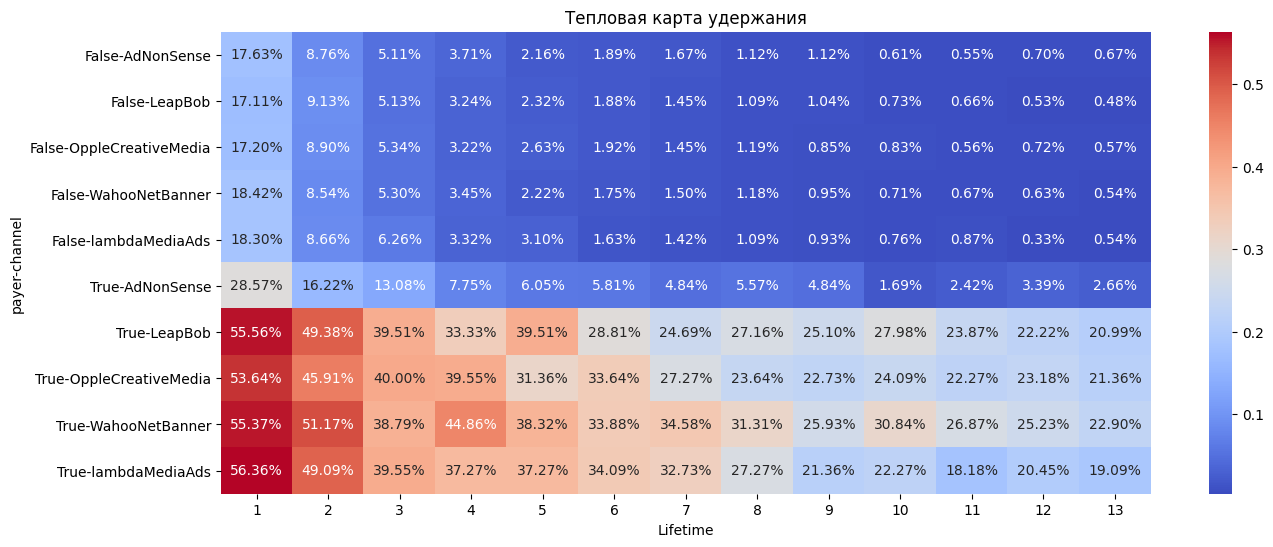

In [52]:
for i in ['United States', ['UK','France','Germany']]:
    retention_raw, retention_grouped, retention_history = get_retention(
        ads_profiles.query('region in @i'), visits, observation_date, horizon_days,['channel'])
    display(HTML(f'<center><span style="color: black; font-size: 2em">Графики удержания по каналам в {i}</span> </center>'))
    plot_retention(retention_grouped, retention_history, horizon_days, window = 7) 
    heatmap_rr()

*Rolling window: 7*
- Удержание когорт платящих пользователей канала FaceBoom заметно ниже всех остальных и полностью схоже с удержанием когорт неплатящих. Динамика удержания так же находится ниже 5 % на протяжении всего периода и так же схожа с динамикой не платящих.
- Удержание когорт платящих пользователей остальных каналов в United States выше неплатящих.
- Динамика удержания канала TipTop имеет постоянные взлёты до 35 % и падения до 10 %. Динамики остальных каналов слишком шумные и имеют постоянные падения и взлёты (вероятнее всего из-за не стабильного потока покупателей).
- Удержание когорт платящих пользователей канала AdNonSense заметно ниже всех остальных и полностью схоже с удержанием когорт неплатящих. Динамика удержания шумная и имеет резкие взлёты и падения.
- Удержание когорт платящих пользователей остальных каналов в странах Europe выше неплатящих. Их динамика удержания шумная и имеет резкие взлёты и падения.

**Итого**
+ В United States проблема с удержанием платящих пользователей канала FaceBoom.
+ В Europe проблема с удержанием платящих пользователей канала AdNonSense.

<a id = 'device_metrics'></a>
### [Метрики по устройствам](#plan)

Построим графики LTV, CAC и ROI с разбивкой по устройствам.

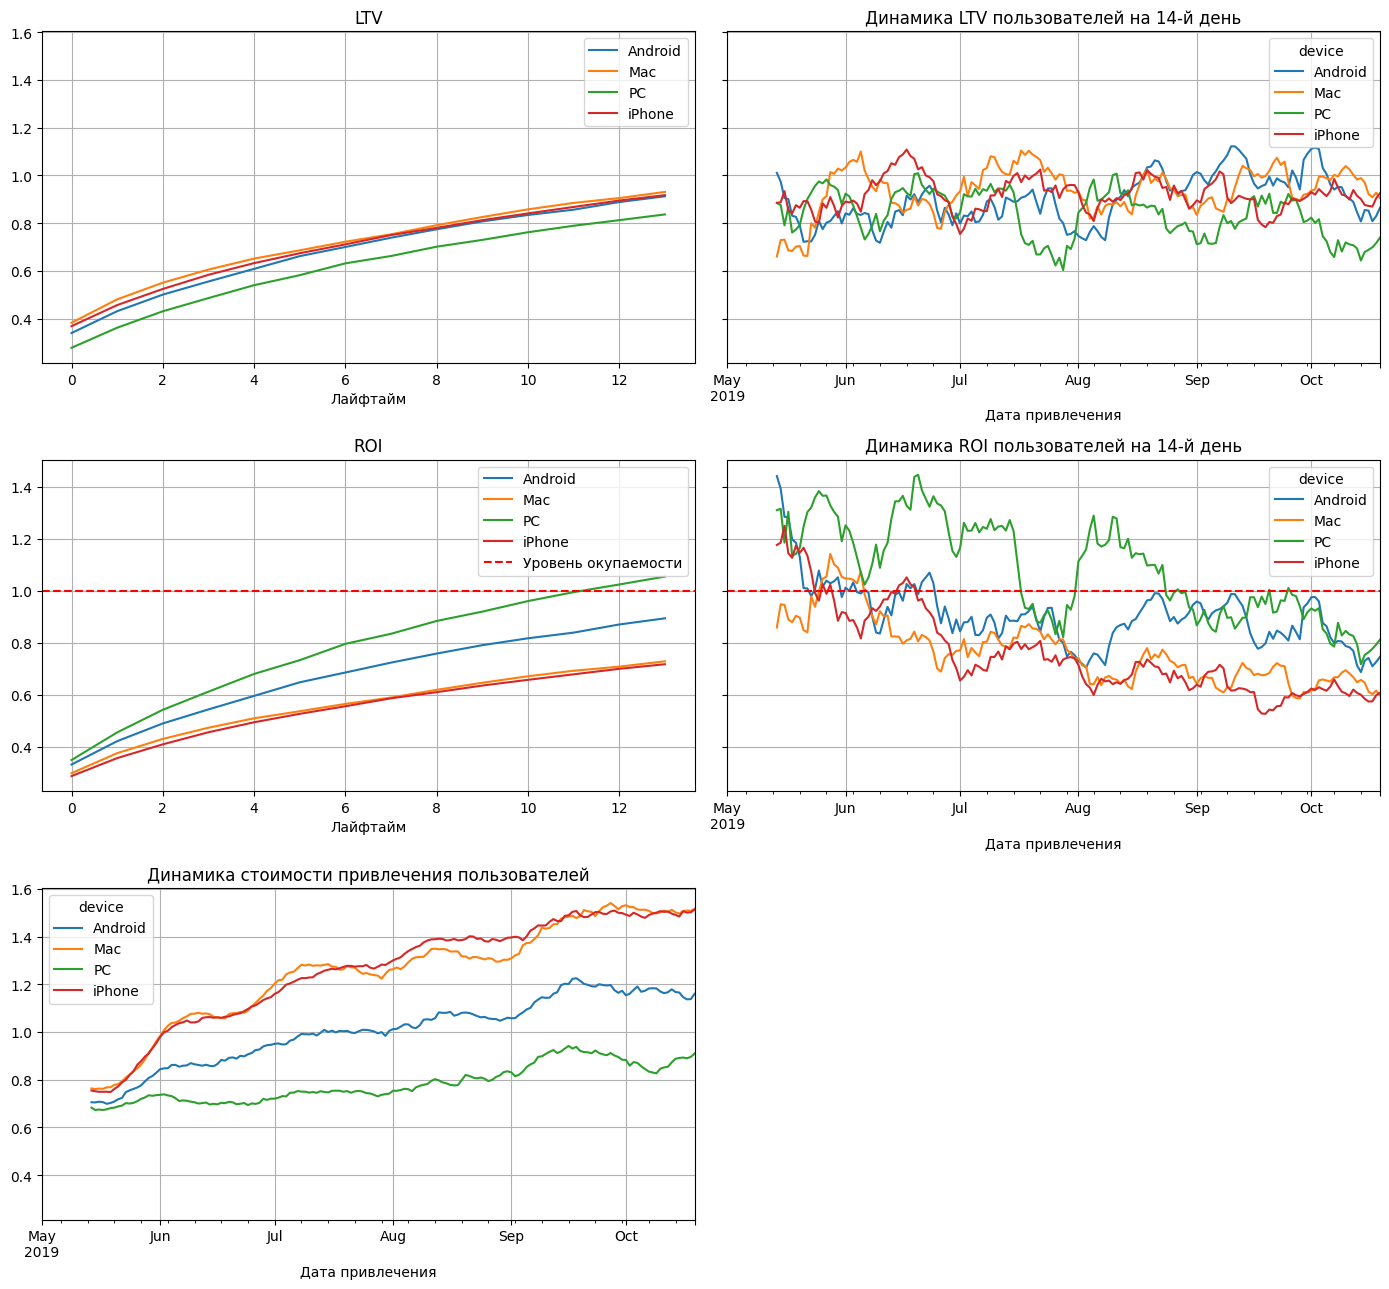

In [53]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ads_profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, ['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window =14)

*Rolling window: 14*
- Окупились только когорты пользователи PC. Но в динамике окупаемости с конца августа они тоже перестали окупаться.
- LTV всех устройств пользователей в среднем стабильны.
- Пользователи Android, Mac, iPhone перестали окупаться с конца мая - начала июня.
- Средняя стоимость привлечения в течении всего периода росла. Менее активно на PC, и более активно на Mac и iPhone.

Проблема в росте стоимости привлечения.

<a id = 'country_metrics'></a>
### [Метрики по странам](#plan)

Построим график с разбивкой по региону.

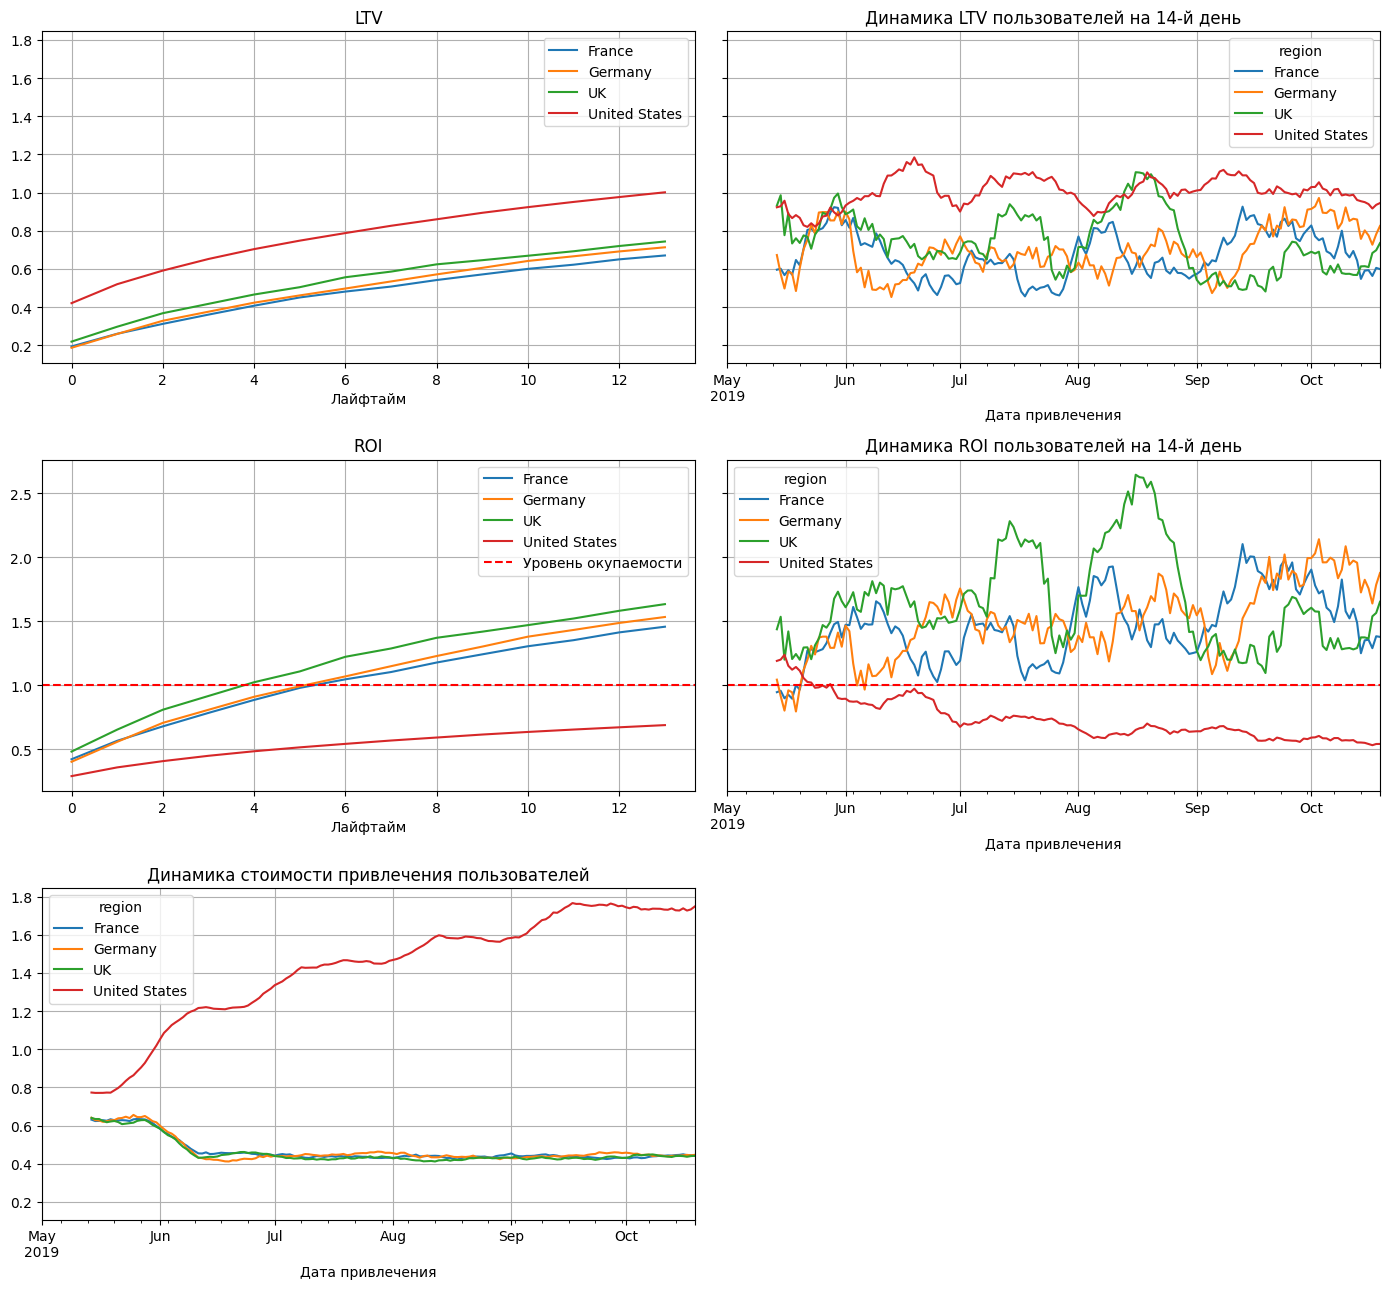

In [54]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ads_profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, ['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window =14)

*Rolling window: 14*
- LTV стабилен. В United States он заметно выше, чем в странах Europe. В динамике это так же на протяжении всего периода. 
- Когорты пользователей из стран Europe окупались в первую неделю лайфтайма. В динамике в течении всего периода выше отметки окупаемости.
- Когорты пользователей из United States не окупались во вторую неделю лайфтайма. В динамике с конца мая перестали окупаться и окупаемость продалжала падение в течении всего оставшегося периода.
- Динамика стоимости привлечения пользователей в странах Europe снизилась в мае.
- Динамика стоимости привлечения пользователей в United States в течении всего периода росла.

Проблема в стоимости привлечения пользователейв United States.

<a id = 'channel_metrics'></a>
### [Метрики по рекламным каналам](#plan)

Построим график с разбивкой по странам и по каналам.

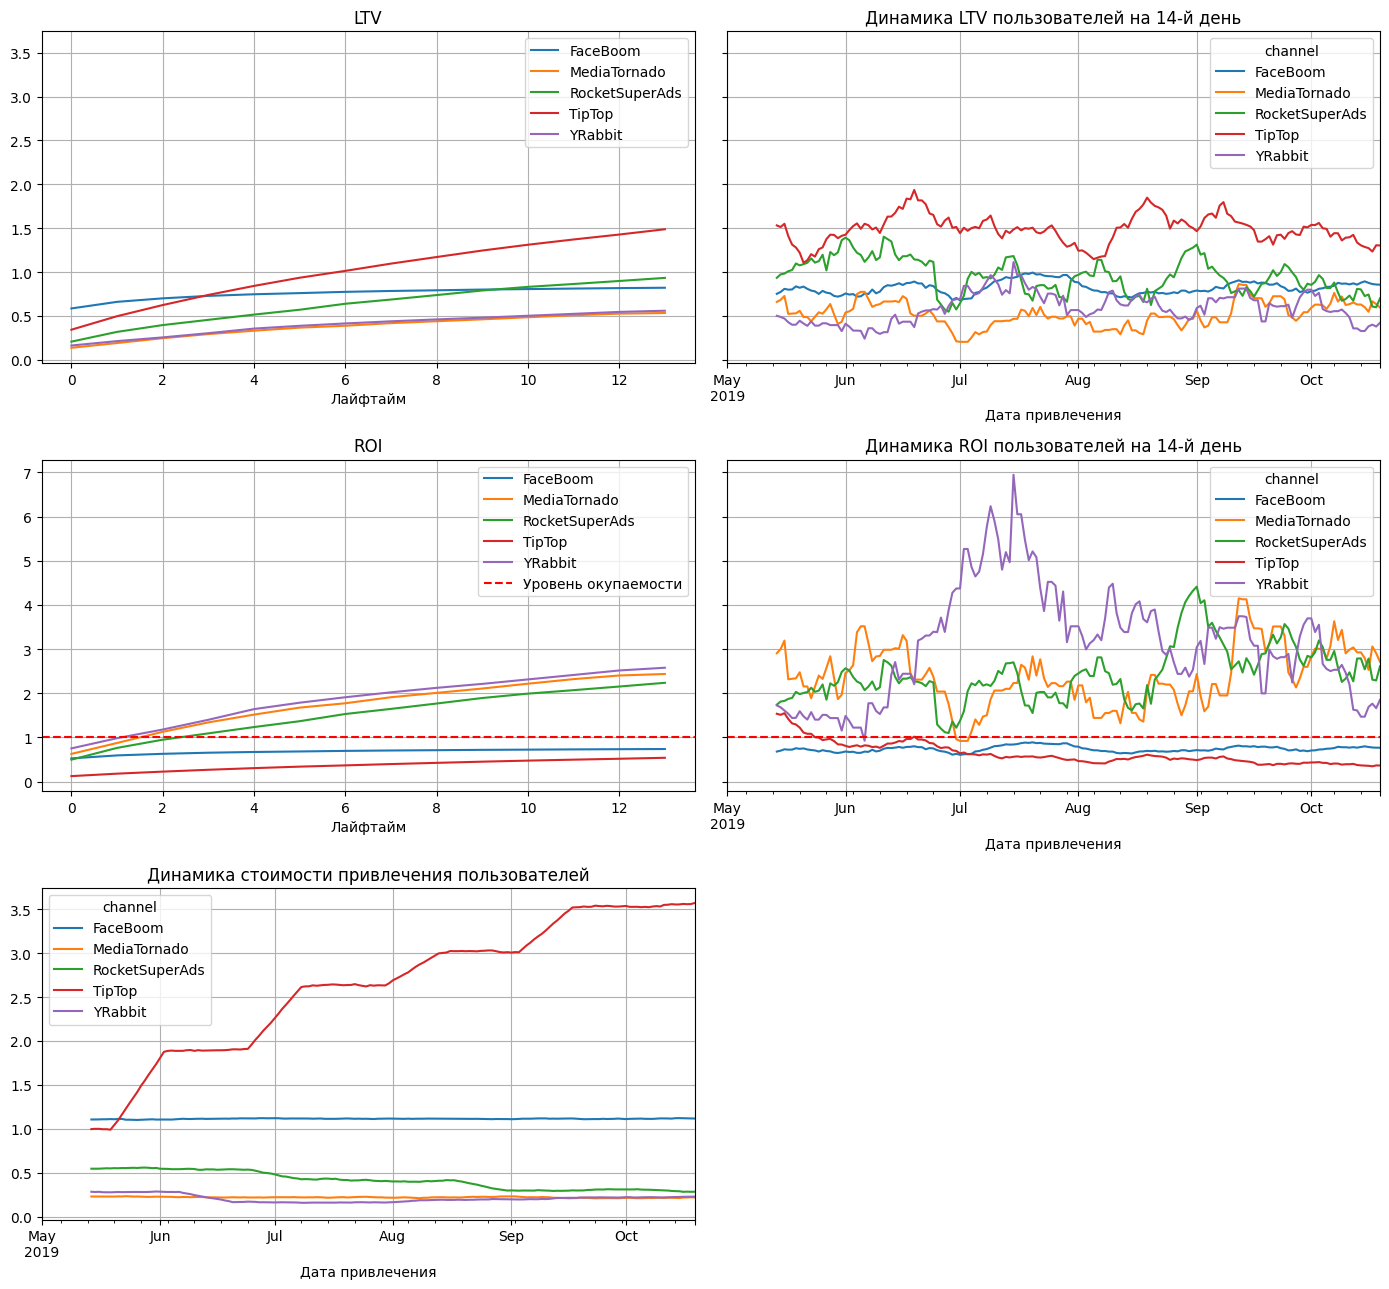

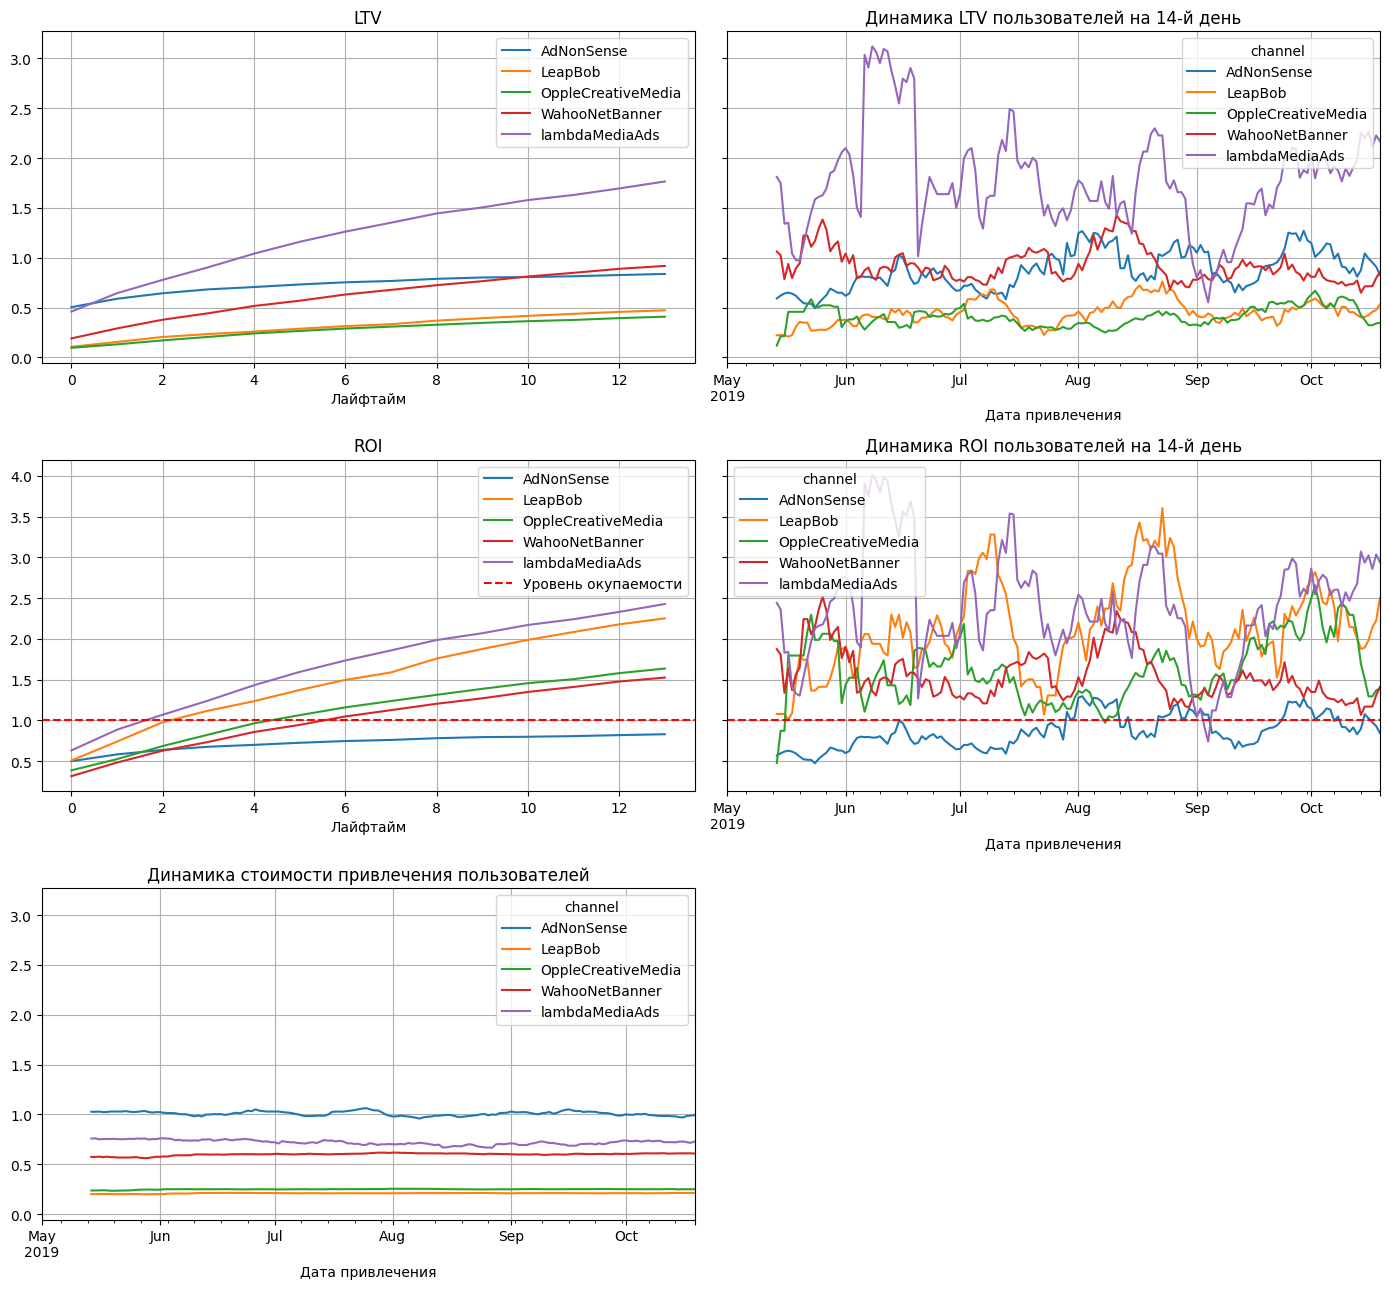

In [55]:
for i in ['United States', ['UK','France','Germany']]:
    ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(ads_profiles.query('region in @i'), 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, ['channel'])
    display(HTML(f'<center><span style="color: black; font-size: 2em">Графики по каналам {i}</span> </center>'))
    plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window =14)

*Rolling window: 14*
- LTV в United States стабилен. У TipTop выше остальных и в динамике находится в диапазоне 100 - 200 %. У FaceBoom в диапазоне 50 - 90 %. У RocketSuperAds от 50 до 150 %. У YRabbit в среднем 30 - 90. А у MediaTornado в пределах 25 - 80 %.
- Когорты каналов TipTop и FaceBoom не окупились на второй неделе лайфтайма и в динамике в среднем находяться ниже порога окупаемости.
- Когорты каналов RocketSuperAds, YRabbit, MediaTornado окупались в середине первой недели. А в динамике в среднем находились выше порога окупаемости в течении всего периода. У YRabbit был широкий всплеск окупаемости в июле- выше, чем у остальных в это время.
- Динамика стоимости привлечения пользователей роста у канала TipTop в течении всего периода. Стоимость привлечения на FaceBoom не изменялся. По остальным каналам в US было небольшое снижение.
-  LTV всех каналов находяться в стабильных диапазонах, кроме lambdaMediaAds, динамика которого скачет в целом от 100 до 300 %.
-  Когорты канала AdNonSence не окупились на вторую неделю лайфтайма и в целом в динамике находятся ниже порога окупаемости на протяжении всего периода.
-  Когорты каналов lambdaMediaAds и LeapBob окупались в среднем в начале первой недели лайфтайма (на второй лайфтайм). Эти каналы выше порога окупаемости на протяжении всего периода, но имеют как резкие взлёты до 350 %, так и падения до 100 %.
- Когорты каналов OppleCreativeMedia и WahooNetBanner окупались в среднем в конце первой недели лайфтайма. Эти каналы так же выше порога окупаемости на протяжении всего периода.
- Динамика стоимости привлечения пользователей не менялась в течении всего периода.

<a id = 'partition_summary_2'></a>
### [Вывод по разделу](#plan)

Инвестиции в рекламу перестали окупатся в начале июня. Не окупилось два крупных рекламных канала в United States (TipTop и FaceBoom) и один небольшой канал в странах Europe (AdNonSense). Общий САС рос на протяжении всего периода и с июня превышал двунедельный LTV. Рост САС вызван ростом стоимости привлечения пользователей у канала TipTop в течении всего периода в United States. При этом стоимость привлечения на FaceBoom и каналам из стран Europe не изменялась. А по остальным каналам в US даже было небольшое снижение. Несмотря на высокие и стабильные показатели конверсии (9.4 %) и показатели удержания у канала TipTop такие же, как и у остальных каналов (кроме FaceBoom) - со временем стоимость привлечения оказалась выше LTV, что привело к убыткам в инвестициях. У каналов FaceBoom и AdNonSense так же высокая конверсия, но LTV в конце второй недели лайфтайма так же был ниже CAC. Пользователи не окупались и проблема была вызвана удержанием покупателей - метрика удержания покупателей в течении лайфтайма такая же как и у простых посетителей. Это так же послужило причиной убыточности инвестиций.

<a id = 'final_results'></a>
## [Итоги исследования](#plan)

Всего новых посетителей: 94.1 % (141127).\
А покупателей: 5.9 % (8881).\
Новые пользователи привлекались в период c 2019-05-01 по 2019-10-27.

**Про страны**\
Основной приток новых посетителей и покупателей из United States (100002 посетителя, 6.9 % покупателей). В Germany посетители чаще становяться покупателями (4.1 %) по сравнению с остальными странами Europe, но количество посетителей наименьшее среди стран Europe (14981). Во France больше смотрять, чем покупают (17450 посетителей, 3.8 % покупателей). В UK посетителей больше всего из стран Europe и хороший процент покупателей (17575 посетителей, 4 % покупателей).

**Про устройства**\
В целом больше всего новых посетителей используют iPhone (54479), а покупателями стали 6.2 %. На втором месте по количеству посетителей Android (35032), покупателями стали 5.9 %. На третьем месте по количеству посетителей пользователи PC (30455), а покупателями стали 5.1 %. На последнем месте по количеству новых посетителей Mac (30042), но пользователи этой платформы чаще становятся покупателями, чем на остальных платформах - 6.4 %.\
Есть предпочтения в использовании определённых устройств среди пользователей из разных стран. 
+ В United States рейтинг популярности устройств новых посетителей: iPhone, Mac, Android, PC.
+ Рейтинг пользовательских устройств покупателей (чаще становятся покупателями) в United States: Android, Mac, PC, iPhone.
+ В UK и Germany рейтинг популятоности устройств новых посетителей и покупателей одинаков: PC, Android, iPhone, Mac.
+ В France рейтинг популярности устройств новых посетителей: PC, Android, iPhone, Mac.
+ Рейтинг пользовательских устройств покупателей (чаще становятся покупателями) в France: Mac, iPhone, PC, Android.

**Про каналы**\
В целом FaceBoom лидер по количеству новых посетителей (29144) и покупателей (12.2 %). AdNonSense, lambdaMediaAds и RocketSuperAds - маленькие каналы (посетителей соотвественно: 3880, 2149, 4448), но покупателями в них становтся чаще (11.34 %, 10.47 %, 7.91 %). TipTop второй по количеству новых посетителей (29144) с большим процентом покупателей (9.6 %). WahooNetBanner - средний по количеству новых посетителей канал (8553), с процентом посетителей меньше, чем предидущие каналы (5.3 %). LeapBob и OppleCreativeMedia - средние каналы по количеству новых посетителей (8553 и 8605), но покупателями из них становяться реже (3.06 % и 2.71 %). Yrabbit и MediaTornado - маленькие каналы по количеству новых посетителей (4312 и 4364). И покупателями из них становяться реже (3.83 % и 3.57 % соотвественно).

В разных странах используются разные каналы - есть чёткое разделение на регионы US и EU.
- Рекламные каналы в United States (в порядке убывания доли покупателей и посетителей):
    * FaceBoom,
    * TipTop,
    * RocketSuperAds,
    * MediaTornado,
    * YRabbit.
- Рекламные каналы в UK, France, Germany (в порядке рейтинга по доле покупателей в каждой стране):
    * WahooNetBanner (первый в Germany по количеству посетителей и третий в UK и France),
    * AdNonSense (четвёртый во всех странах Europe по количеству посетителей),
    * LeapBob (второй в UK и France, и третий в Germany по количеству посетителей),
    * lambdaMediaAds (на последнем месте о всех странах Europe по количеству посетителей),
    * OppleCreativeMedia (на первом месте в UK и France по количеству посетителей и второй в Germany).
- В UK OppleCreativeMedia работала лучше по конверсии в покупателей, чем lambdaMediaAds.

**Про маркетинг**\
Общая сумма инвестиций составила: 105497.3.\
За весь период 82.65 % инвестиций пришлось на популярны каналы в United States - TipTop (54751.3 - это 51.9 %) и FaceBoom (32445.6 - 30.8 %). При том, что итоговый САС этих каналов - самый большой. У TipTop он на порядок выше, чем у FaceBoom. У AdNonSense САС близок к FaceBoom.\
В динамике САС у канала TipTop ступенчато рос на протяжении всего периода с интервалом в 5 недель. А у RocketSuperAds он ненамного снижался на протяжении всего периода. У остальных каналов САС был стабилен или с незначительными изменениями.

**Источники убытков**\
Инвестиции в рекламу перестали окупатся в начале июня. Не окупилось два крупных рекламных канала в United States (TipTop и FaceBoom) и один небольшой канал в странах Europe (AdNonSense). Общий САС рос на протяжении всего периода и с июня превышал двунедельный LTV. Рост САС вызван ростом стоимости привлечения пользователей у канала TipTop в течении всего периода в United States. При этом стоимость привлечения на FaceBoom и каналам из стран Europe не изменялась. А по остальным каналам в US даже было небольшое снижение. Несмотря на высокие и стабильные показатели конверсии (9.6 %) и показатели удержания у канала TipTop такие же, как и у остальных каналов (кроме FaceBoom) - со временем стоимость привлечения оказалась выше LTV, что привело к убыткам в инвестициях. У каналов FaceBoom и AdNonSense так же высокая конверсия, но LTV в конце второй недели лайфтайма так же был ниже CAC. Пользователи не окупались и проблема была вызвана удержанием покупателей - метрика удержания покупателей в течении лайфтайма такая же как и у простых посетителей. Это так же послужило причиной убыточности инвестиций.

Учитывая, что на канал TipTop ушла половина бюджета инвестиций, а его окупаемость падает из-за повышения САС, то рекомендую приостановить инвестиции, либо их снизить и найти точки роста для повышения уровня LTV (повышения выручки). По каналу FaceBoom и AdNonSanse рекомендую проработать повышение удержания. Так же возможно стоит ребалансировать инвестиции и направить их части в другие рекламные каналы привлечения. В United States выглядит перспективным канал RocketSuperAds. Возможно стоит ввести еженедельные отчёты по ключевым метрикам в разбивке регионов нахождения рекламных каналов.

___
[🡅🡅🡅](#top)